In [1]:
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
sns.set()

In [2]:
from covid_tracking_data.collector import *
from covid_analysis.utility import *
from covid_analysis.models import *
from ourworldindata_org.collector import *

In [3]:
 from matplotlib.axes._axes import _log as matplotlib_axes_logger
 matplotlib_axes_logger.setLevel('ERROR')

### Fetch the latest data

If the interface is overloaded, the collector will retry every few seconds.

In [4]:
df, states_in_order = get_dataset_df()
fns = save_data(df, states_in_order)
print("data saved to {} and {}".format(*fns))

data saved to /Users/drskippy/data/2020-04-10_1555_state_daily_data.csv and /Users/drskippy/data/2020-04-10_1555_state_rank.csv


### Fetch data set from local disk

In [5]:
!ls ~/data/
# gets thte latest file names
recent = ! ls -drt ~/data/* | tail -n 2
print("Latest files are:\n\t{}\n\t{}".format(*recent))

2020-04-07_2224_state_daily_data.csv 2020-04-09_1613_state_rank.csv
2020-04-07_2224_state_rank.csv       2020-04-10_1539_state_daily_data.csv
2020-04-08_2053_state_daily_data.csv 2020-04-10_1539_state_rank.csv
2020-04-08_2053_state_rank.csv       2020-04-10_1555_state_daily_data.csv
2020-04-09_1613_state_daily_data.csv 2020-04-10_1555_state_rank.csv
Latest files are:
	/Users/drskippy/data/2020-04-10_1555_state_daily_data.csv
	/Users/drskippy/data/2020-04-10_1555_state_rank.csv


In [6]:
df, states_in_order = get_dataset_df_from_file(recent)
df.head()

date state  positive  negative  pending  hospitalizedCurrently  \
0 2020-03-04    NY       6.0      48.0     24.0                    NaN   
1 2020-03-05    NY      22.0      76.0     24.0                    NaN   
2 2020-03-06    NY      33.0      92.0    236.0                    NaN   
3 2020-03-07    NY      76.0      92.0    236.0                    NaN   
4 2020-03-08    NY     105.0      92.0      NaN                    NaN   

   hospitalizedCumulative  inIcuCurrently  inIcuCumulative  \
0                     NaN             NaN              NaN   
1                     NaN             NaN              NaN   
2                     NaN             NaN              NaN   
3                     NaN             NaN              NaN   
4                     NaN             NaN              NaN   

   onVentilatorCurrently  ...  tests  posNeg fips daily_new_death  \
0                    NaN  ...     54      54   36             NaN   
1                    NaN  ...     98      98   36             0.0   
2                    NaN  ...    125     125   36             0.0   
3                    NaN  ...    168     168   36             0.0   
4                    NaN  ...    197     197   36             0.0   

   hospitalizedIncrease  negativeIncrease  daily_new_positive  \
0                   NaN               NaN                 NaN   
1                   0.0              28.0                16.0   
2                   0.0              16.0                11.0   
3                   0.0               0.0                43.0   
4                   0.0               0.0                29.0   

   totalTestResultsIncrease  order  last_update  
0                       NaN      0   2020-04-09  
1                      44.0      0   2020-04-09  
2                      27.0      0   2020-04-09  
3                      43.0      0   2020-04-09  
4                      29.0      0   2020-04-09  

[5 rows x 27 columns]

In [7]:
dfus = get_state_df(df, "*", additional_aggregation_keys=["negative", "pending"])
dfus["sum_of_tests"] = dfus["positive"] + dfus["negative"] + dfus["pending"]
dfus.tail()

date  positive  daily_new_positive    death  daily_new_death  \
37 2020-04-05  333220.0             26293.0   9542.0           1168.0   
38 2020-04-06  362171.0             28951.0  10705.0           1163.0   
39 2020-04-07  393357.0             31186.0  12628.0           1923.0   
40 2020-04-08  423637.0             30280.0  14495.0           1867.0   
41 2020-04-09  457963.0             34326.0  16399.0           1904.0   

      tests   negative  pending  sum_of_tests  
37  1763652  1430432.0  17307.0     1780959.0  
38  1910310  1548139.0  17292.0     1927602.0  
39  2058060  1664703.0  16557.0     2074617.0  
40  2197743  1774106.0  17228.0     2214971.0  
41  2360512  1902549.0  17631.0     2378143.0

### Zero-day normalized log of total verified covid-19 cases

Improvment in flattening slopes. (The "grass" blows over to the right.)

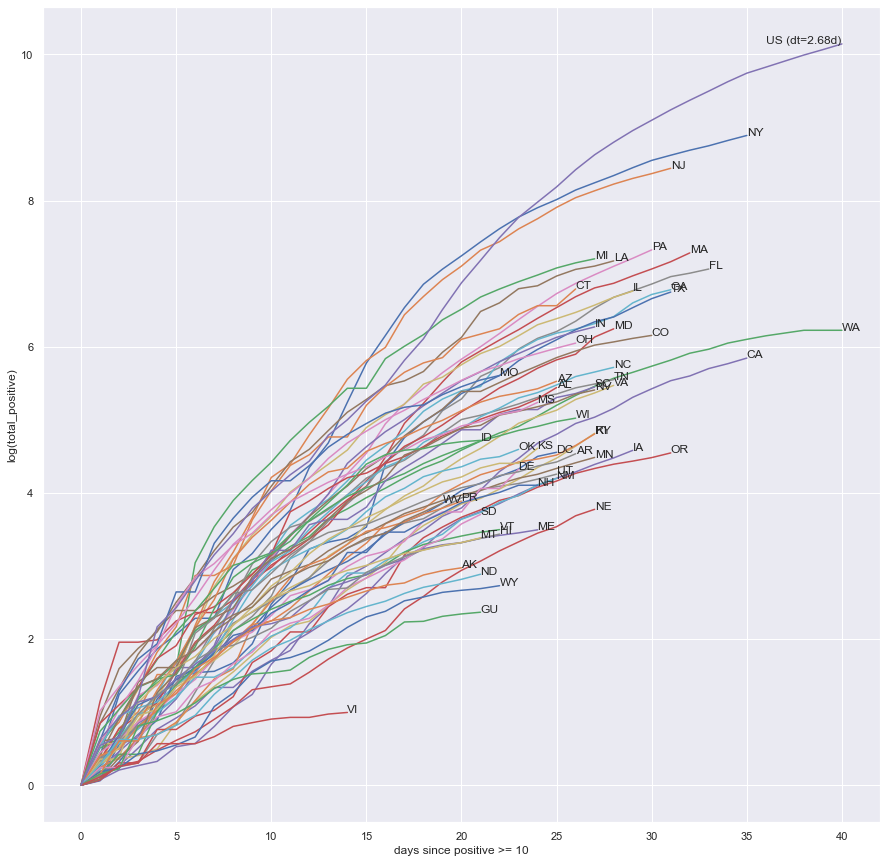

In [8]:
# start after day with min_pos or more cases
min_pos = 10
last_n_days = None

# image
plt.figure(figsize=[15,15])

key_value = "days_since_{}".format(min_pos)

# state by state
for s in states_in_order:
    try:
        dfq = get_state_df(df, s)
        dfq = get_zero_aligned_log_positive(dfq, min_pos=min_pos, use_last_n_days=last_n_days)
        plt.plot(dfq[key_value].values, dfq.log_positive.values)
        plt.annotate(s, (dfq[key_value].values[-1], dfq.log_positive.values[-1]))
    except IndexError:
        pass

# All US image
try:        
    dfq, dt, params = get_state_doubling_df(df, "*")
    dfq = get_zero_aligned_log_positive(dfq, min_pos=min_pos, use_last_n_days=last_n_days)
    plt.plot(dfq[key_value].values, dfq.log_positive.values)
    xus = int(.9* dfq[key_value].values[-1])
    plt.annotate("US (dt={:1.2f}d)".format(dt), (xus , dfq.log_positive.values[-1]))
except IndexError:
    pass

plt.xlabel("days since positive >= {}".format(min_pos))
plt.ylabel("log(total_positive)")
plt.show()

### US Total verifice covid-19 cases; current doubling period and history of doubling periods

Use the last few days to estimate the current doubling period. Plot the with past data for context.

US Total Positive, doubling every 6.99 days
  as of 2020-02-28T00:00
  based on last 10 days of data


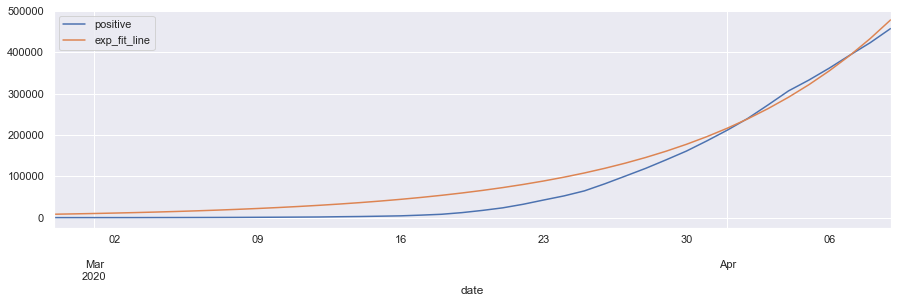

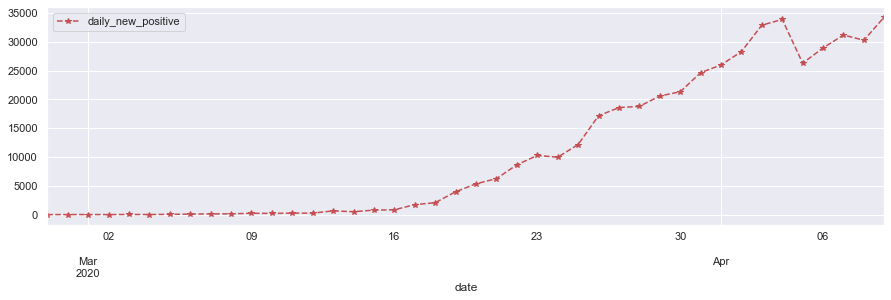

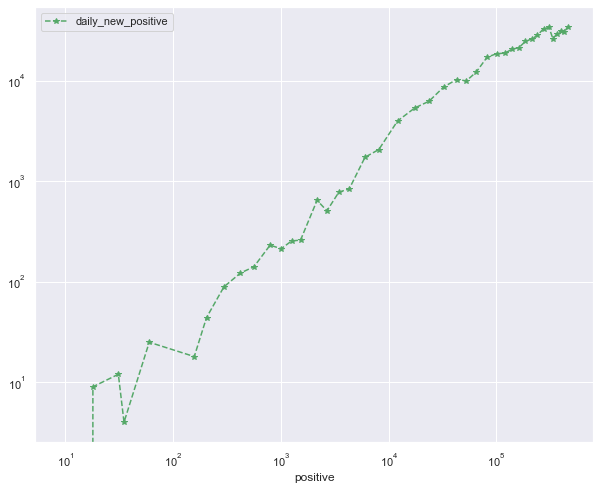

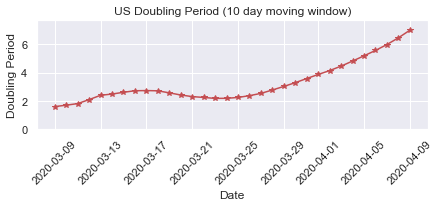

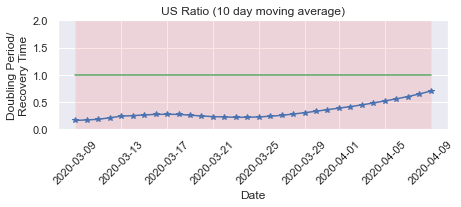

In [9]:
last_n_days = 10
dfa, dt, _ = get_state_doubling_df(df, "*", use_last_n_days=last_n_days)
lu = str(dfa.date.values[0])[:16]
print("US Total Positive, doubling every {:.3} days\n  as of {}".format(dt, lu))
print("  based on last {} days of data".format(last_n_days))
dfa.plot(x="date", y=["positive", "exp_fit_line"], figsize=[15,4])
dfa.plot(x="date", y="daily_new_positive", figsize=[15,4], style="*--r")
dfa.plot(x="positive", y="daily_new_positive", figsize=[10,8], style="*--g", logy=True, logx=True)
period_factor_plot(dfq, "*", ylimit=2)
plt.show()

### Testing data

Test positive rate is the number of covid-19 positive test over the total number of tests.

Uncertainty in the total number of tests due to the emerging private testing?

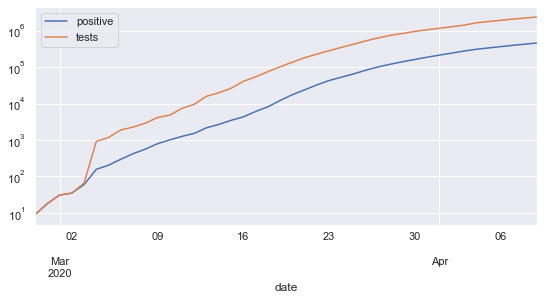

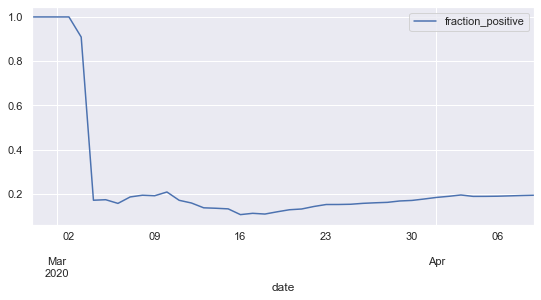

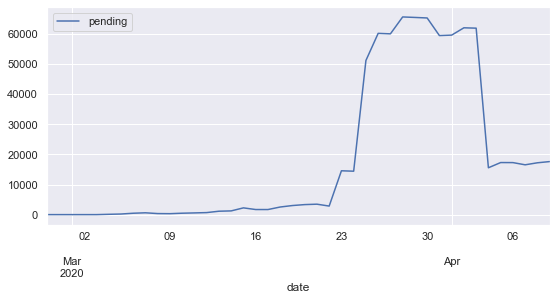

In [10]:
dfus["fraction_positive"] = dfus["positive"]/ dfus["tests"]
ax = dfus.plot(x="date", y="positive", logy=True, figsize=[9,4])
dfus.plot("date", "tests", logy=True, ax=ax)
dfus.plot("date", "fraction_positive", figsize=[9,4])
dfus.plot("date", "pending", figsize=[9,4])

### Current measured ratios and percentages; raw projections for the next few doubling periods

These are based on cases that test postive and test negative (state labs policies vary on this).

In [11]:
print("Current strategies for diagnosis give pos/neg tests ratio of {:.1%}".format(
    dfus.positive.values[-1]/(dfus.tests.values[-1])))
print("on total tests tracked = {:,}".format(int(dfus.tests.values[-1])))

Current strategies for diagnosis give pos/neg tests ratio of 19.4%
on total tests tracked = 2,360,512


In [12]:
pos_dr = dfus.death.values[-1]/dfus.positive.values[-1]
print("Current death/positive ratio of {:.1%}".format(pos_dr))

Current death/positive ratio of 3.6%


### State Trends and Doubling Periods

State=NY  (last_update=2020-03-04T00:00)
Doubling every 8.41 days based on last 10 days of data


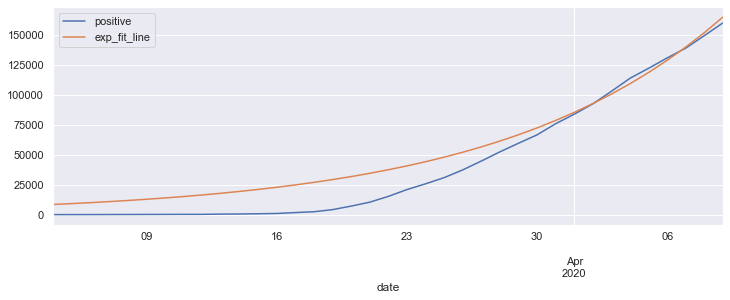

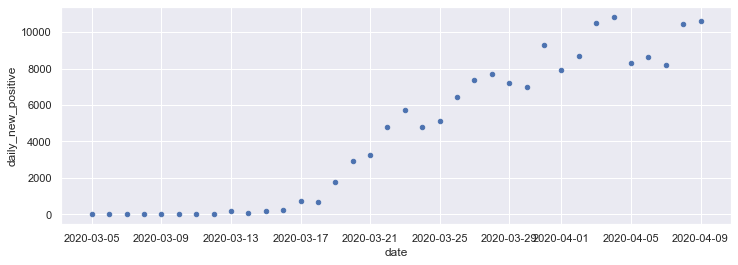

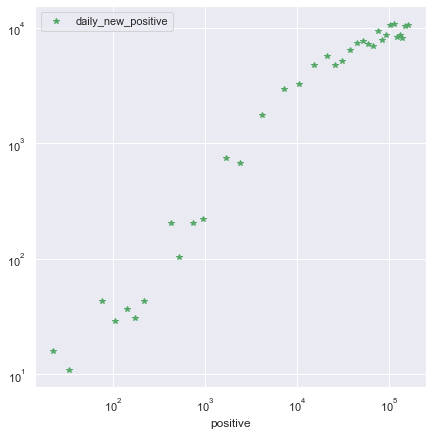

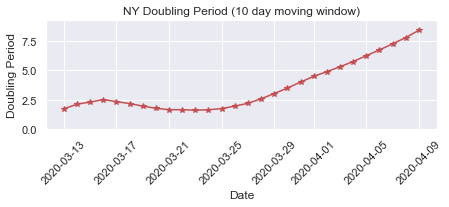

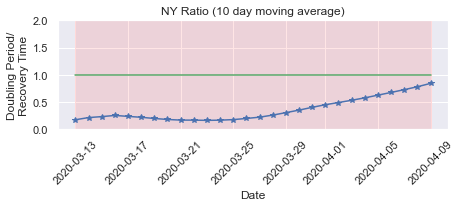

State=NJ  (last_update=2020-03-05T00:00)
Doubling every 6.3 days based on last 10 days of data


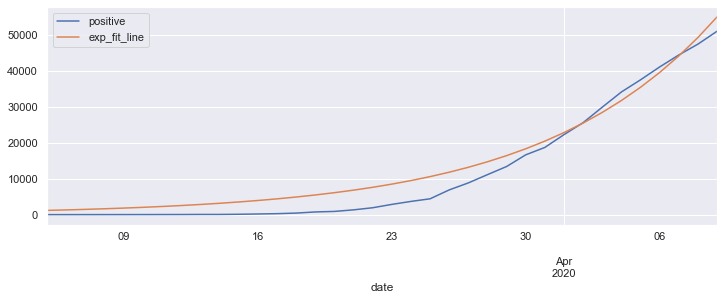

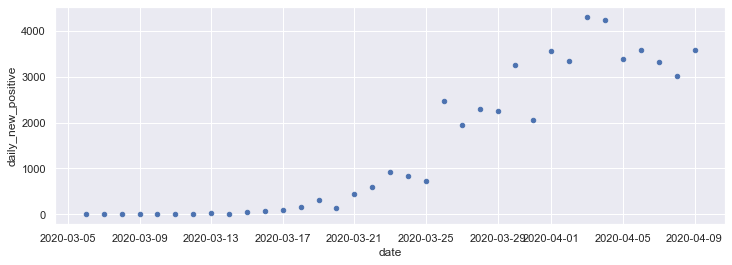

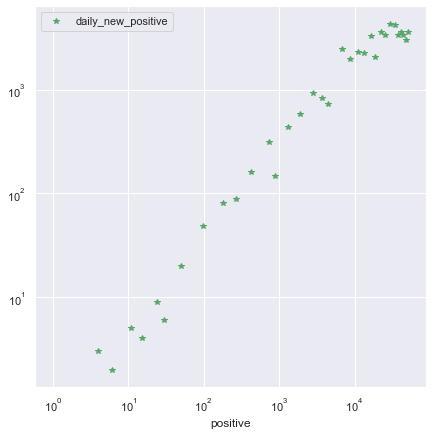

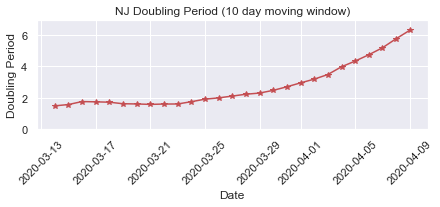

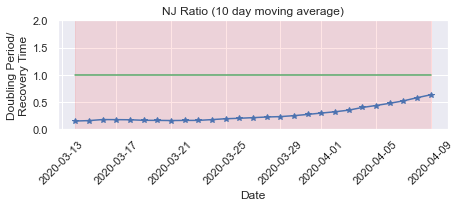

State=MI  (last_update=2020-03-05T00:00)
Doubling every 6.14 days based on last 10 days of data


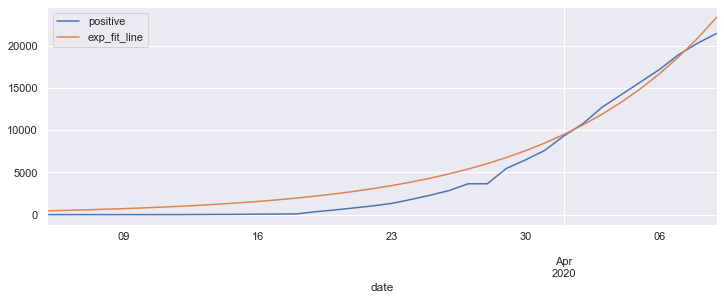

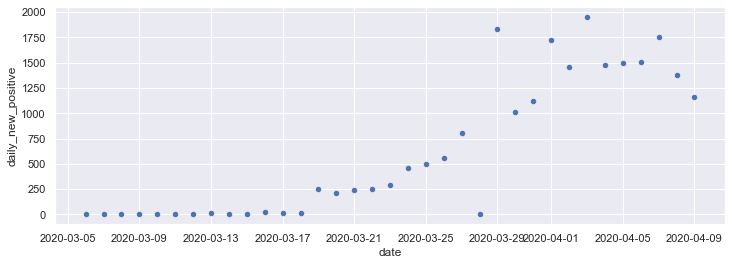

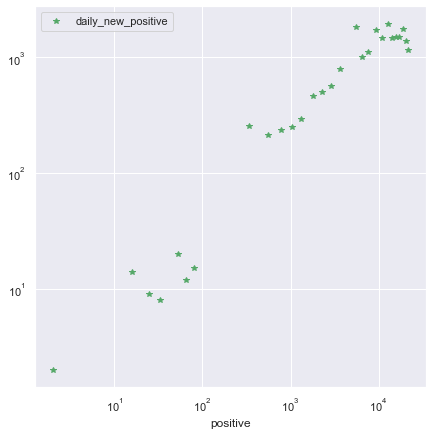

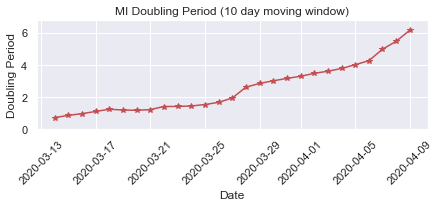

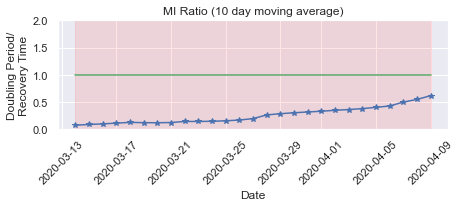

State=MA  (last_update=2020-03-04T00:00)
Doubling every 6.2 days based on last 10 days of data


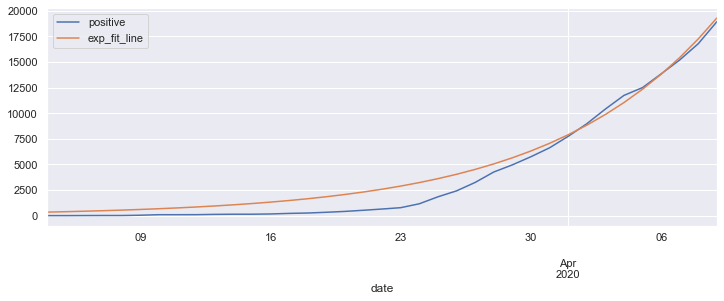

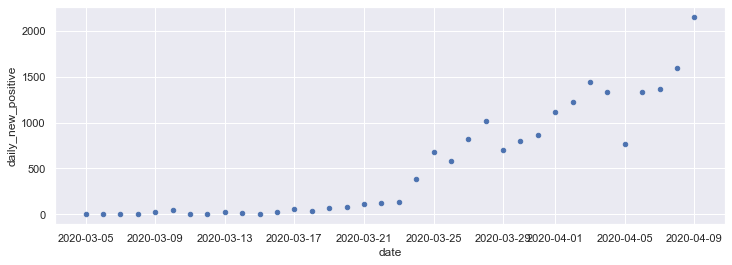

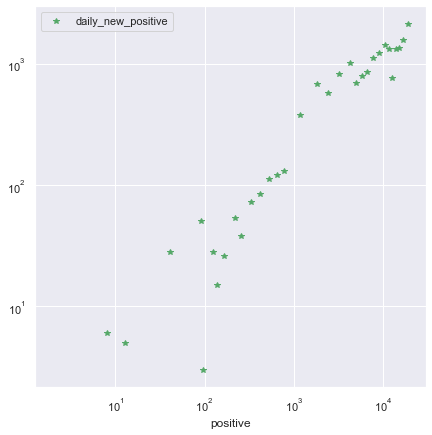

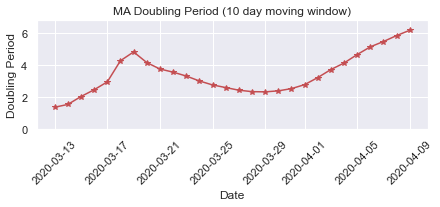

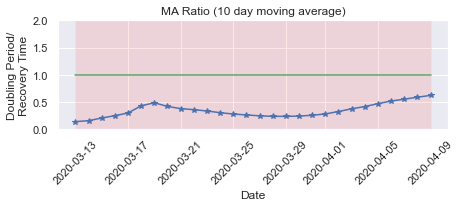

State=CA  (last_update=2020-03-04T00:00)
Doubling every 6.77 days based on last 10 days of data


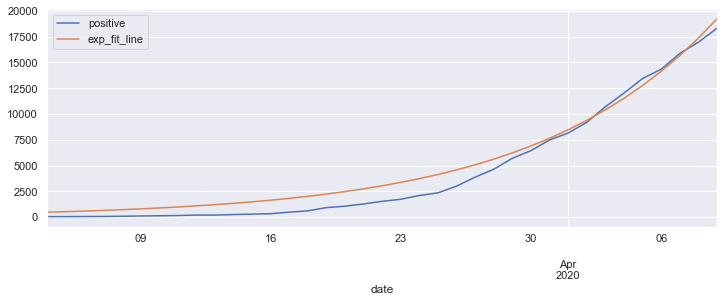

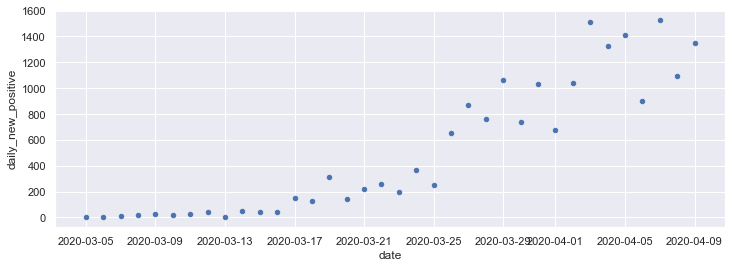

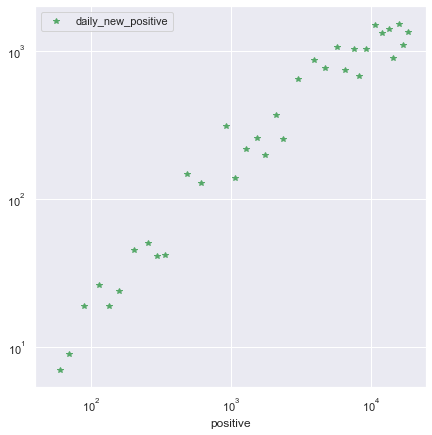

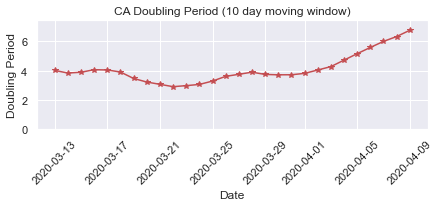

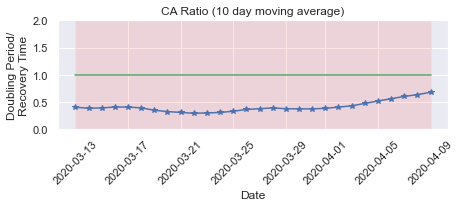

State=LA  (last_update=2020-03-07T00:00)
Doubling every 5.17 days based on last 10 days of data


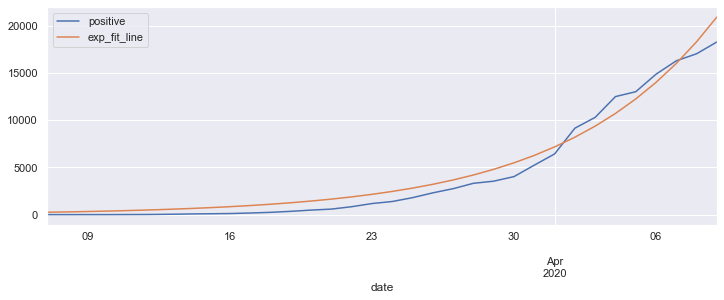

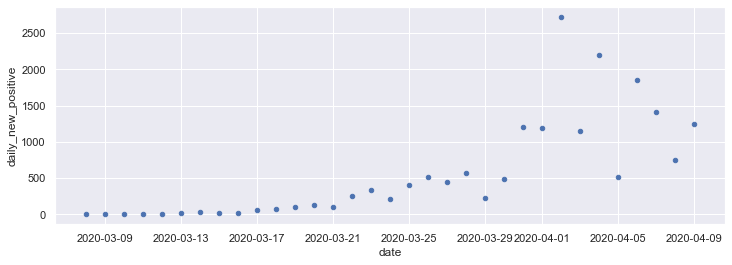

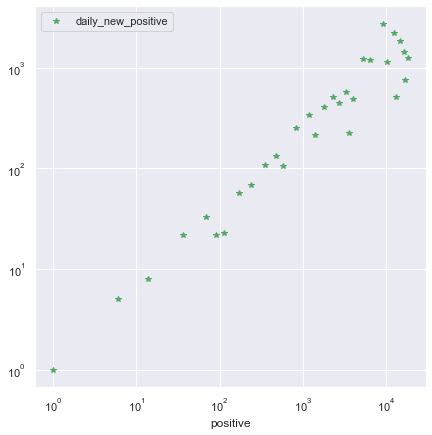

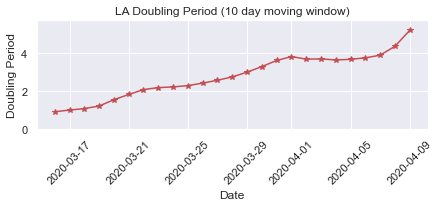

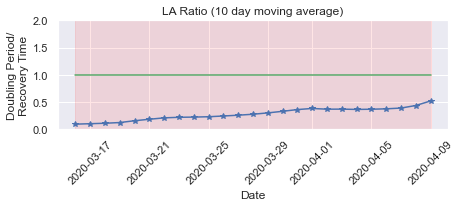

State=PA  (last_update=2020-03-06T00:00)
Doubling every 4.72 days based on last 10 days of data


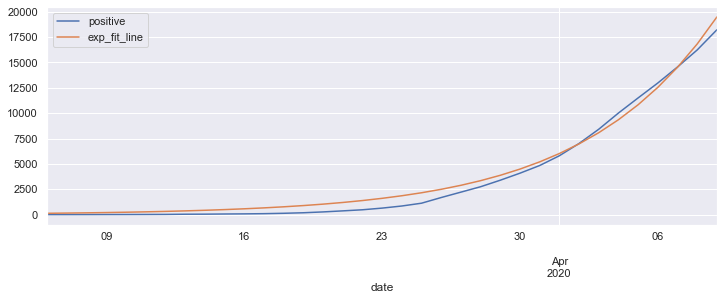

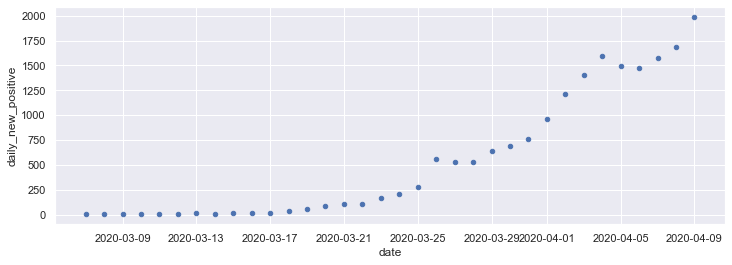

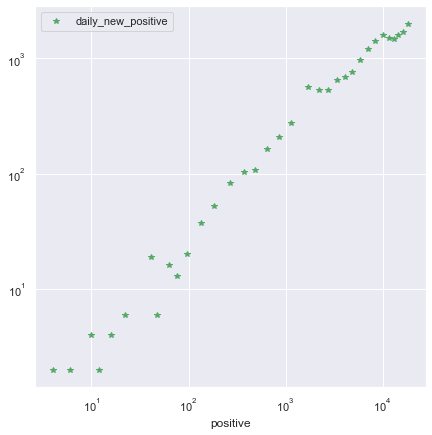

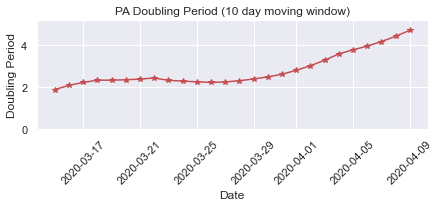

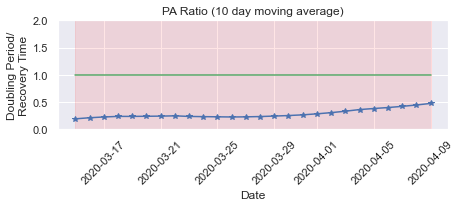

State=FL  (last_update=2020-03-04T00:00)
Doubling every 6.26 days based on last 10 days of data


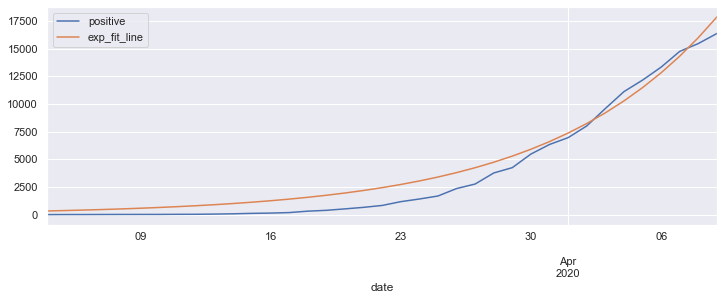

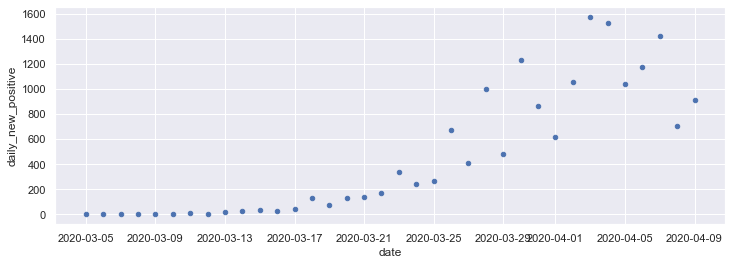

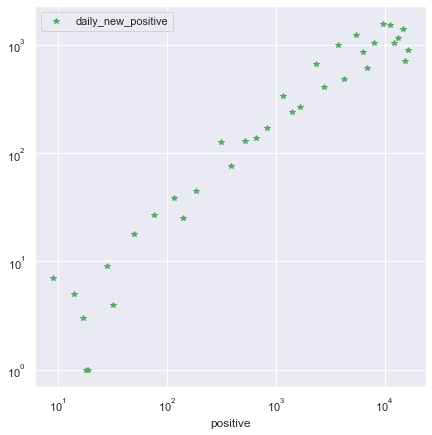

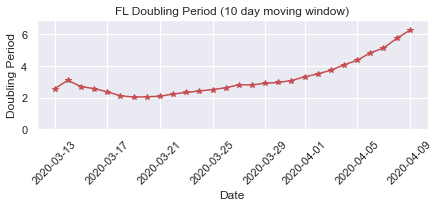

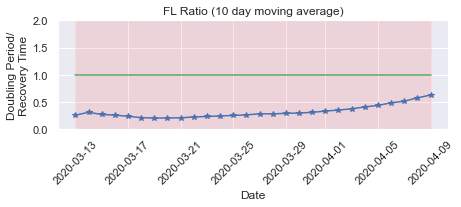

State=IL  (last_update=2020-03-04T00:00)
Doubling every 6.24 days based on last 10 days of data


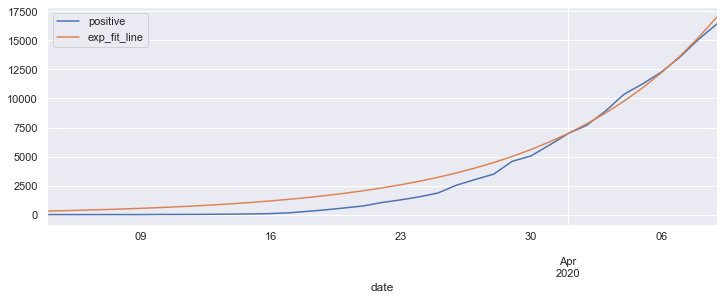

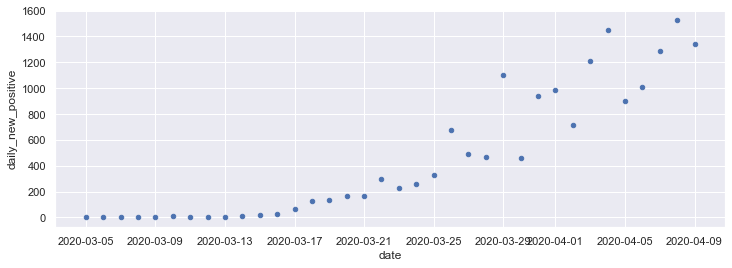

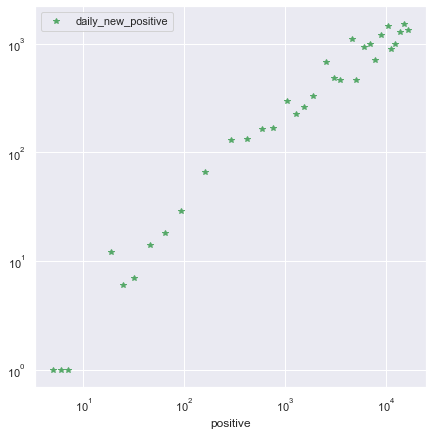

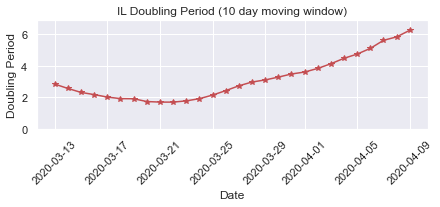

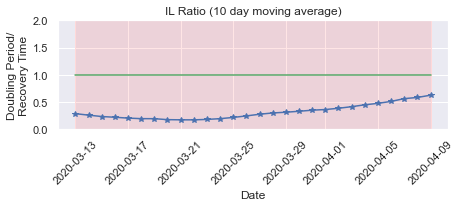

State=GA  (last_update=2020-03-04T00:00)
Doubling every 6.55 days based on last 10 days of data


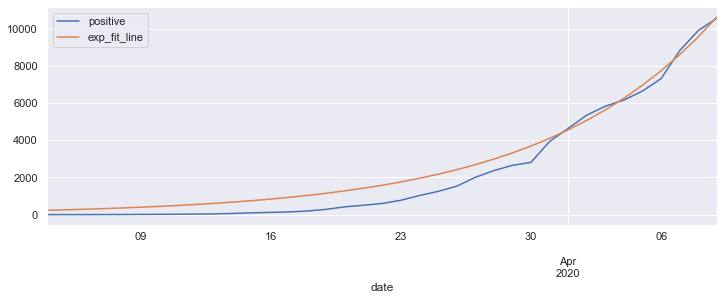

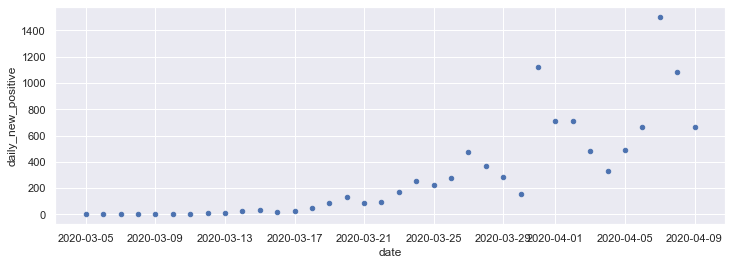

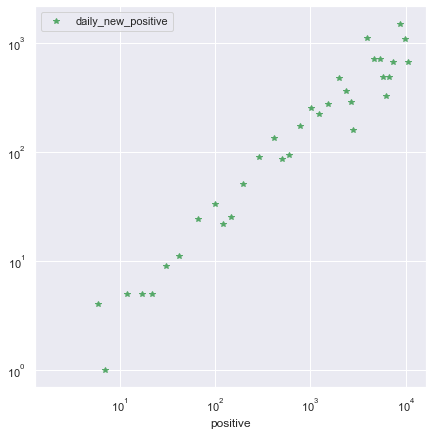

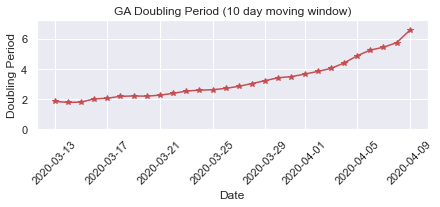

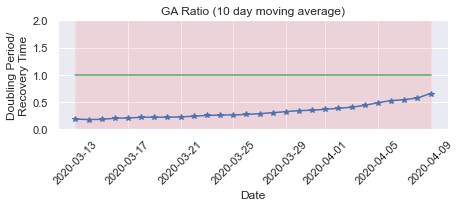

State=TX  (last_update=2020-03-04T00:00)
Doubling every 5.68 days based on last 10 days of data


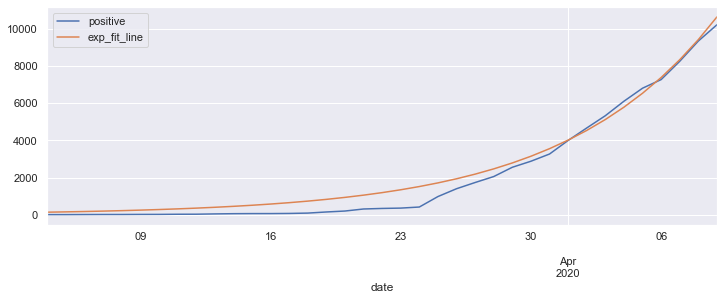

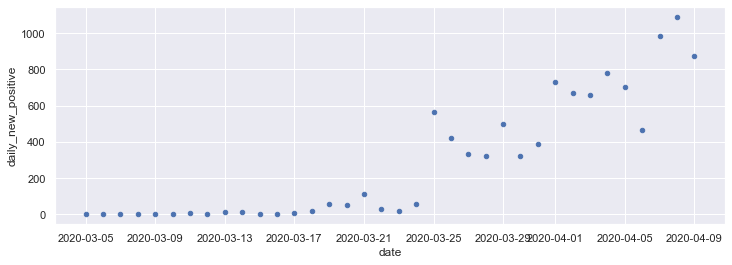

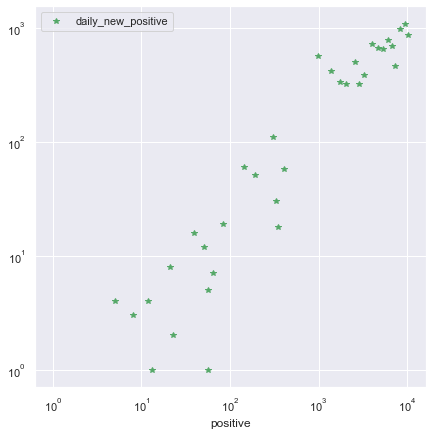

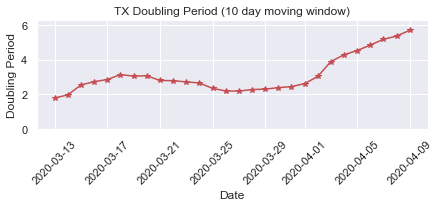

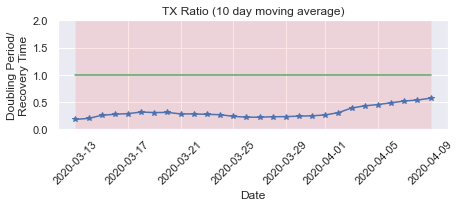

State=CT  (last_update=2020-03-07T00:00)
Doubling every 5.61 days based on last 10 days of data


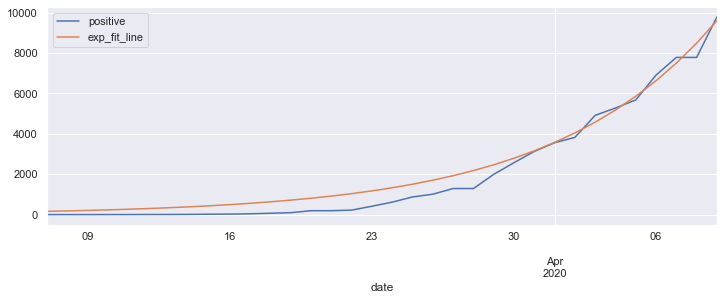

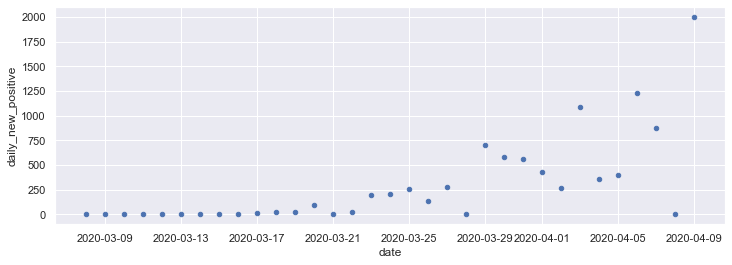

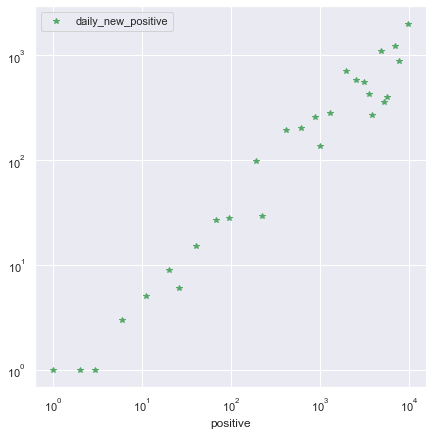

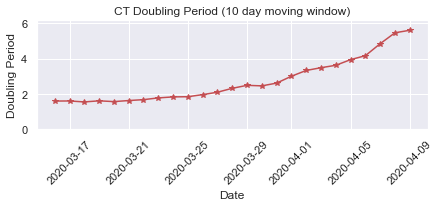

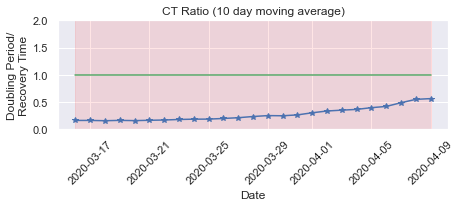

State=WA  (last_update=2020-02-28T00:00)
Doubling every 15.0 days based on last 10 days of data


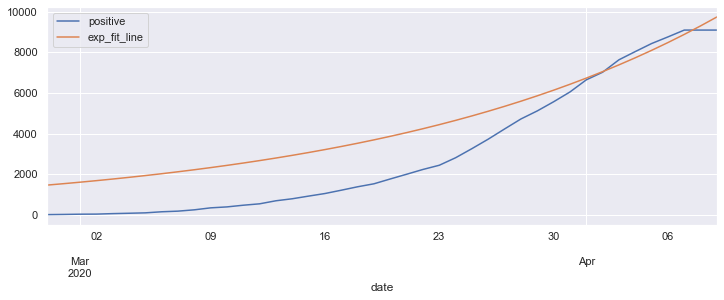

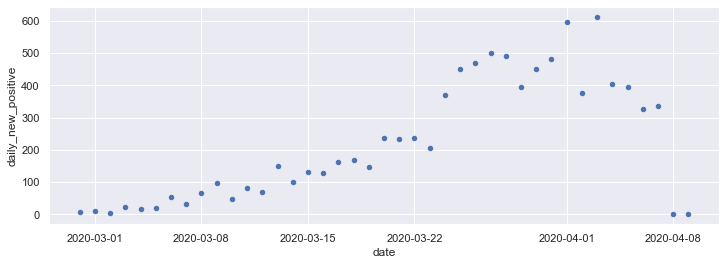

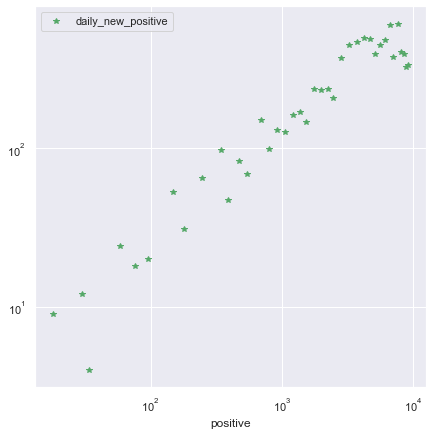

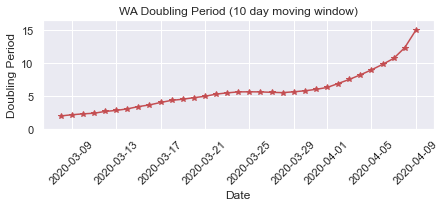

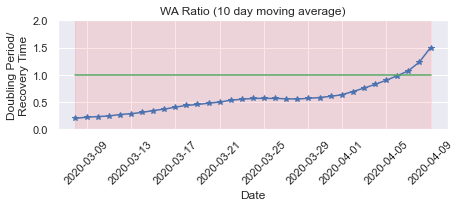

State=MD  (last_update=2020-03-05T00:00)
Doubling every 4.88 days based on last 10 days of data


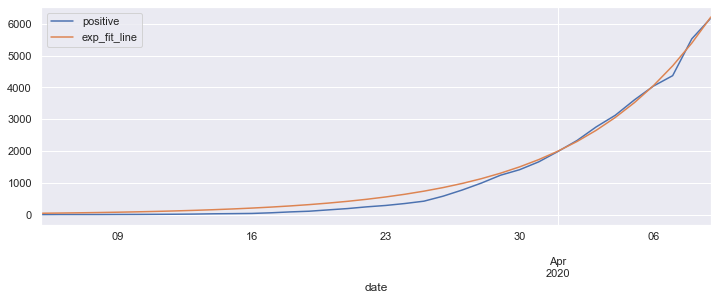

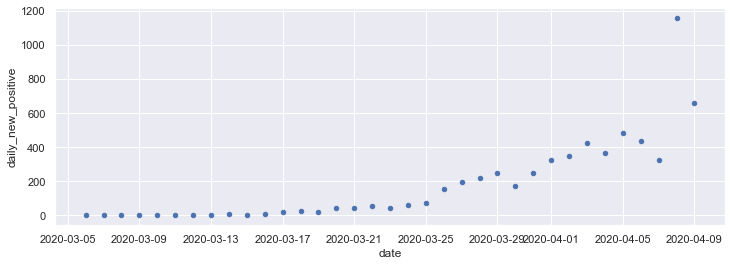

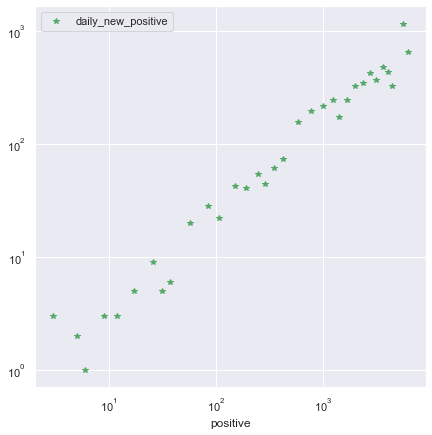

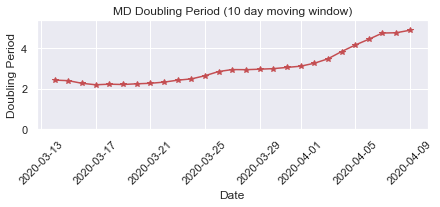

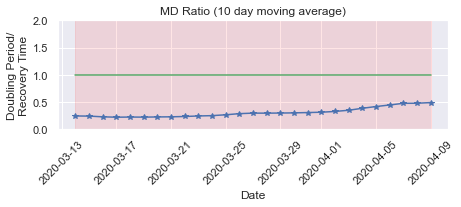

State=IN  (last_update=2020-03-06T00:00)
Doubling every 5.79 days based on last 10 days of data


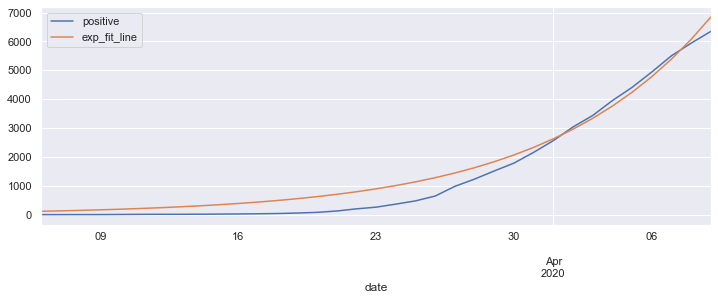

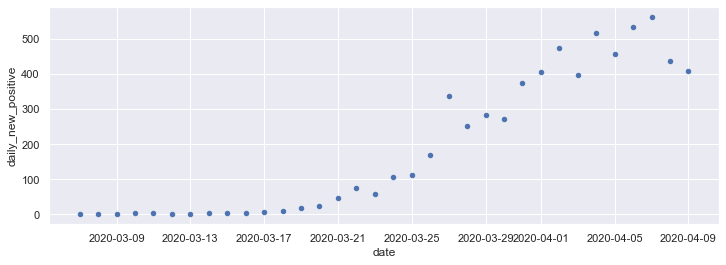

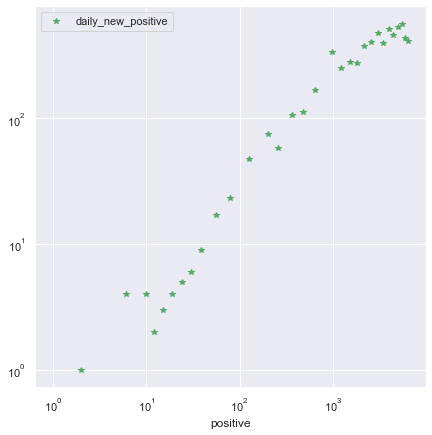

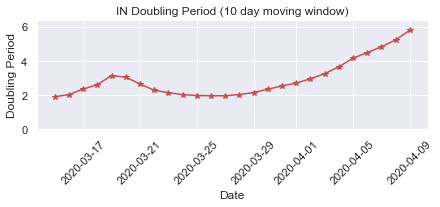

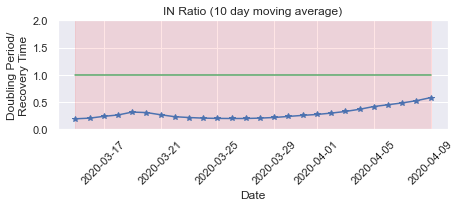

State=CO  (last_update=2020-03-05T00:00)
Doubling every 8.02 days based on last 10 days of data


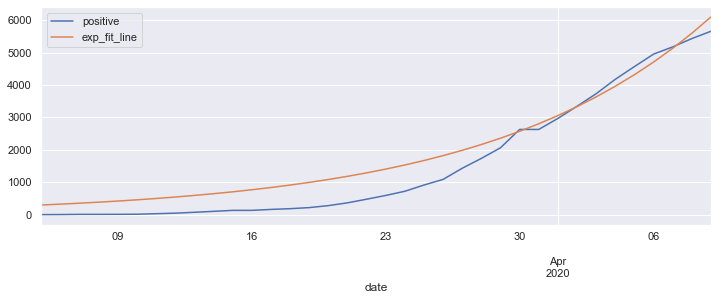

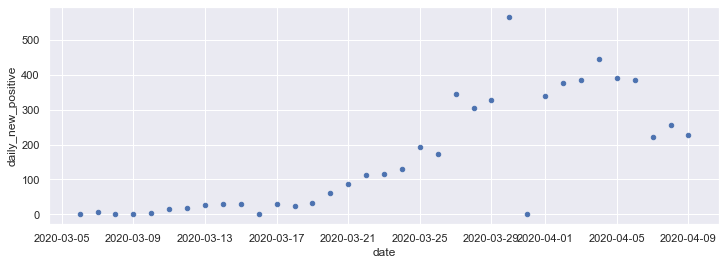

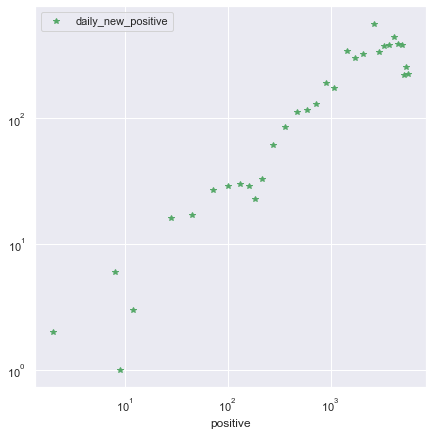

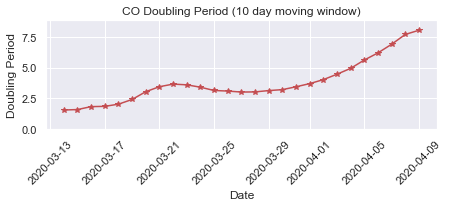

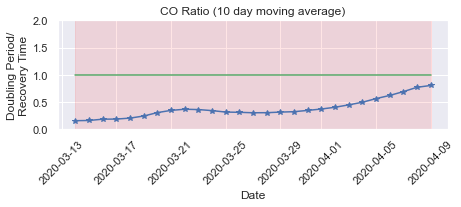

State=OH  (last_update=2020-03-05T00:00)
Doubling every 6.87 days based on last 10 days of data


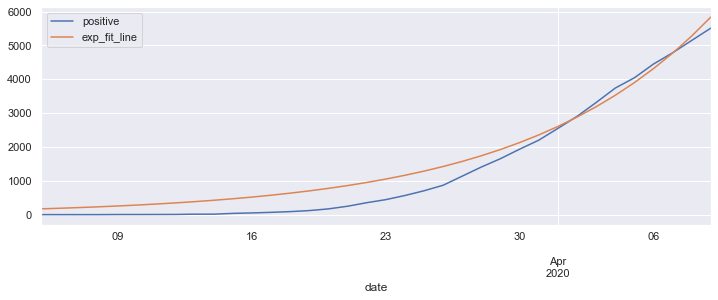

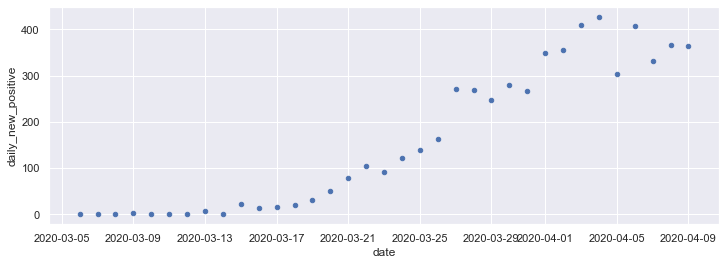

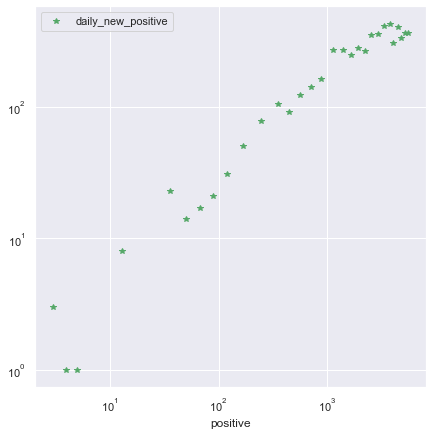

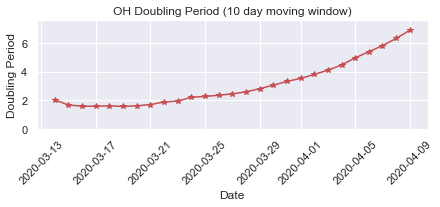

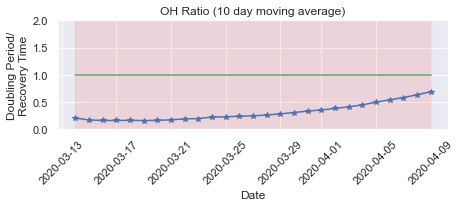

State=TN  (last_update=2020-03-05T00:00)
Doubling every 9.11 days based on last 10 days of data


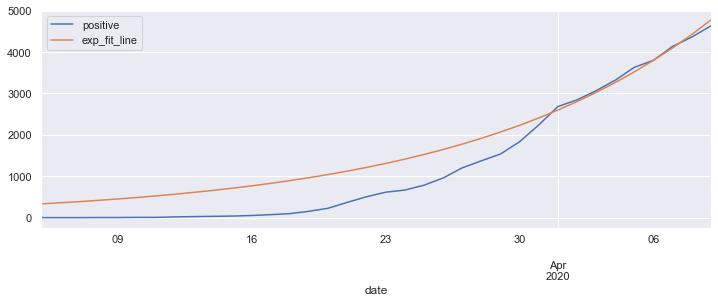

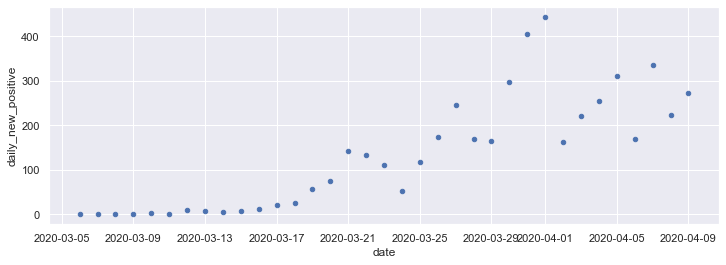

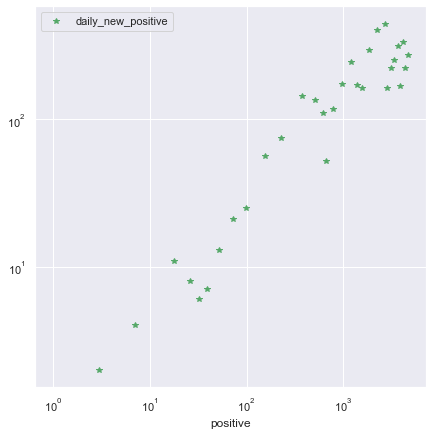

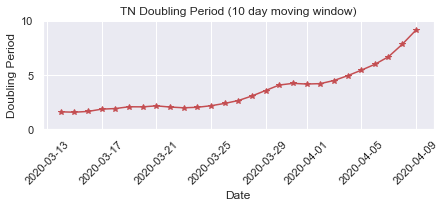

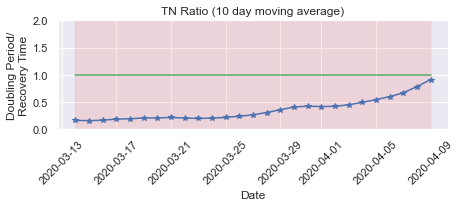

State=VA  (last_update=2020-03-05T00:00)
Doubling every 5.35 days based on last 10 days of data


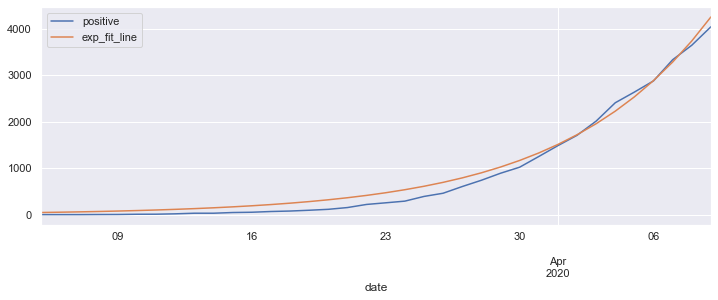

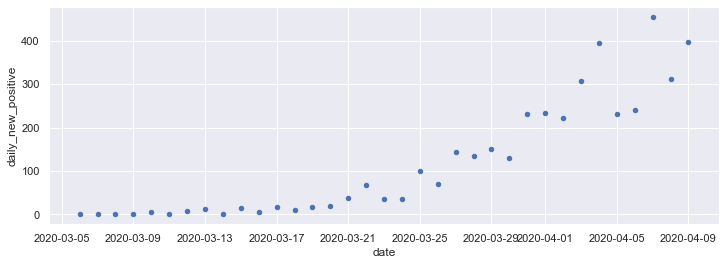

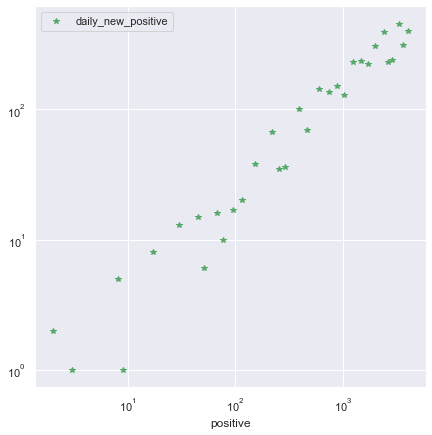

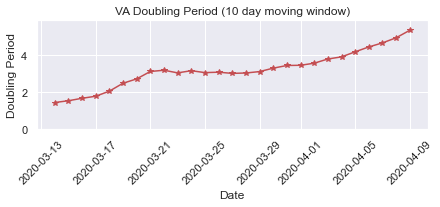

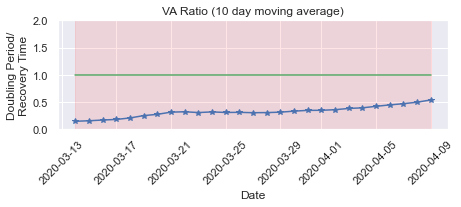

State=NC  (last_update=2020-03-04T00:00)
Doubling every 6.65 days based on last 10 days of data


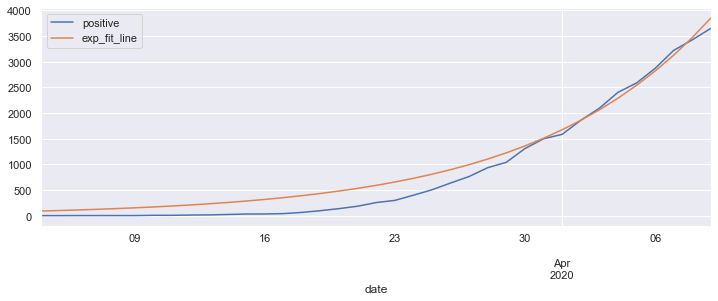

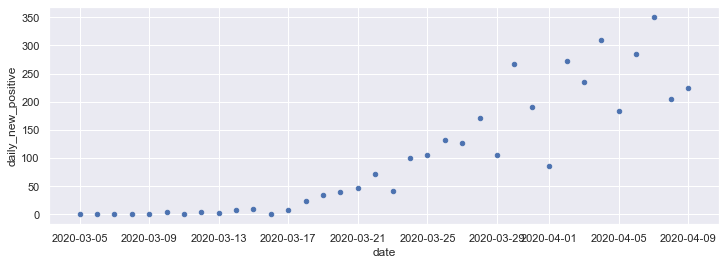

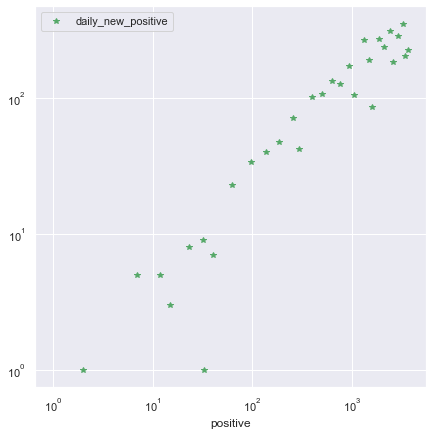

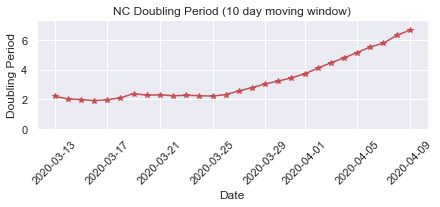

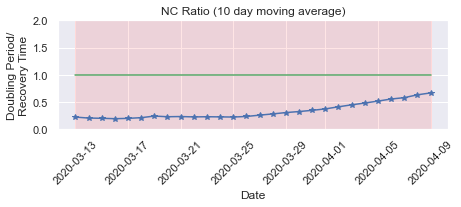

State=MO  (last_update=2020-03-07T00:00)
Doubling every 6.59 days based on last 10 days of data


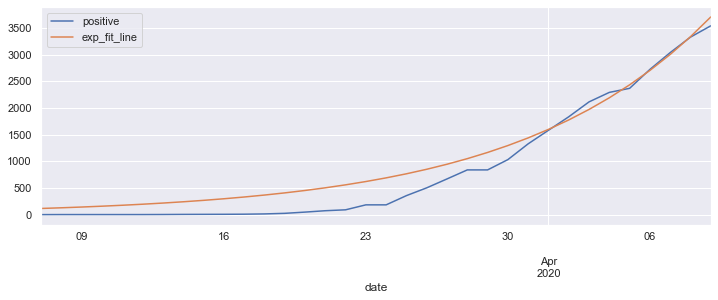

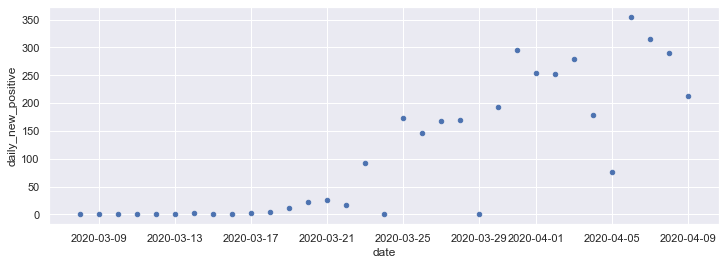

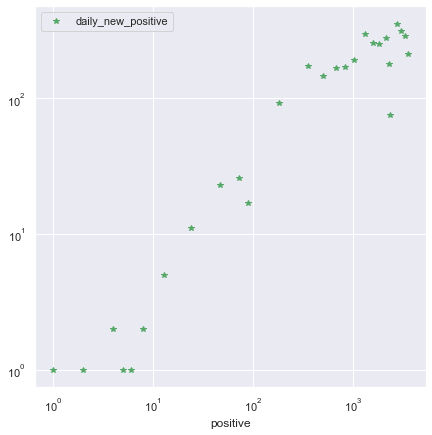

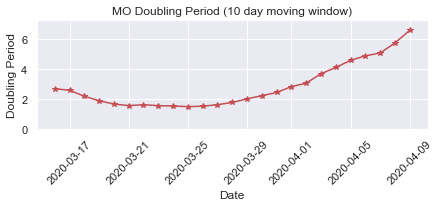

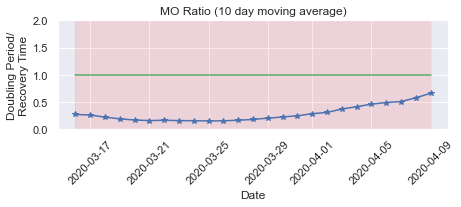

State=AZ  (last_update=2020-03-04T00:00)
Doubling every 7.26 days based on last 10 days of data


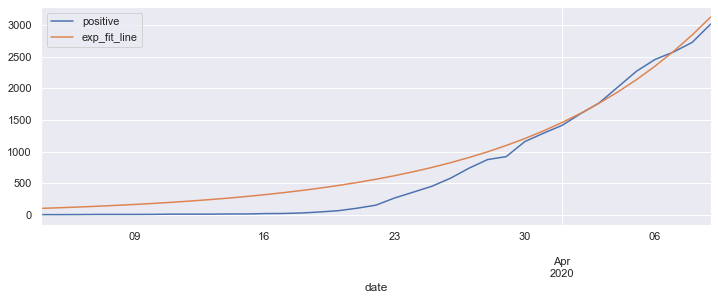

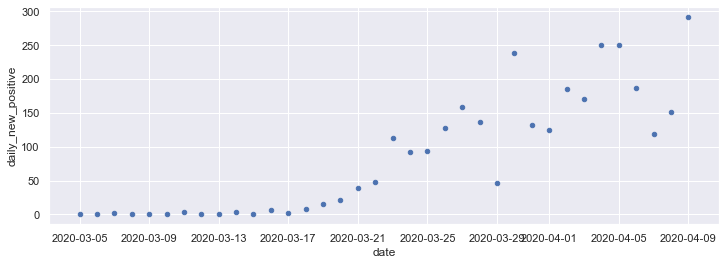

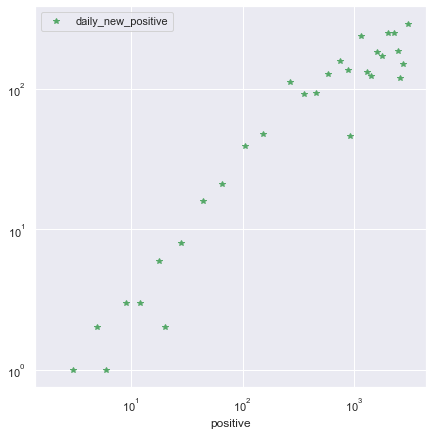

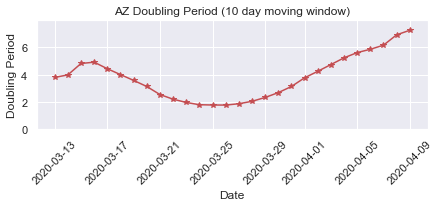

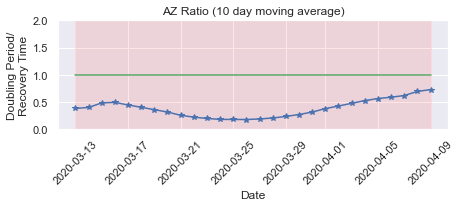

State=WI  (last_update=2020-03-04T00:00)
Doubling every 8.38 days based on last 10 days of data


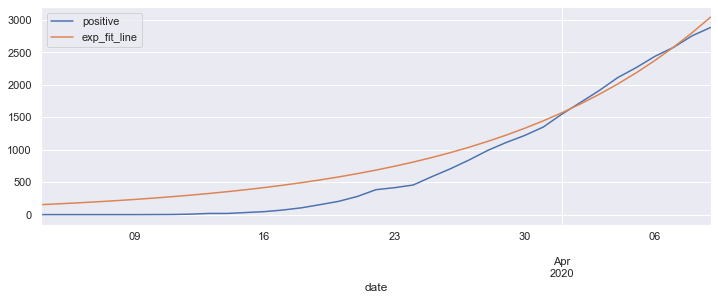

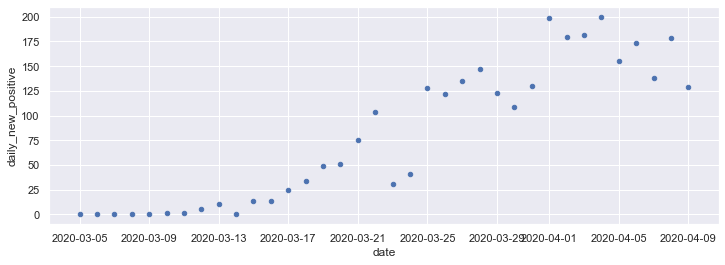

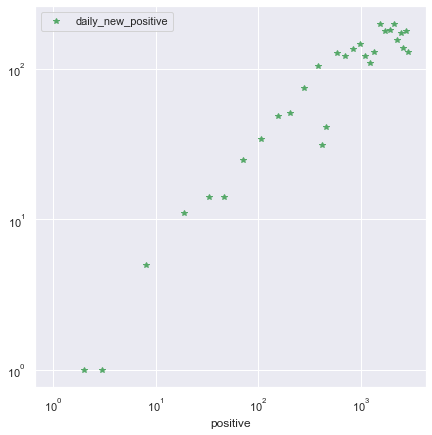

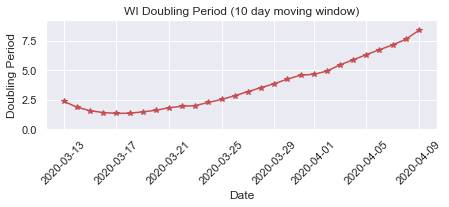

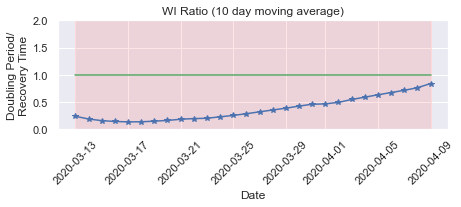

State=AL  (last_update=2020-03-07T00:00)
Doubling every 6.13 days based on last 10 days of data


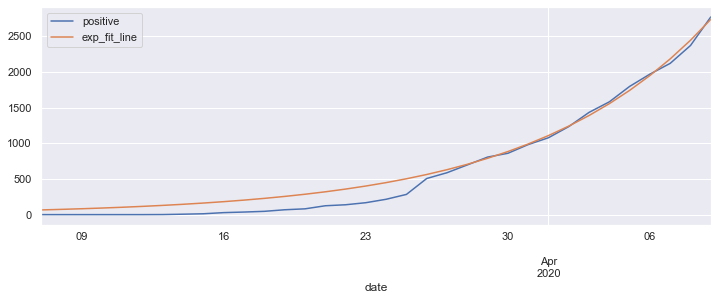

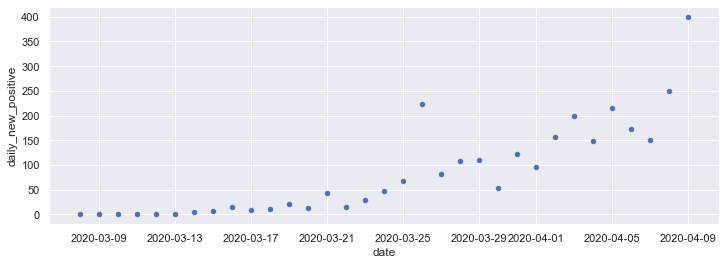

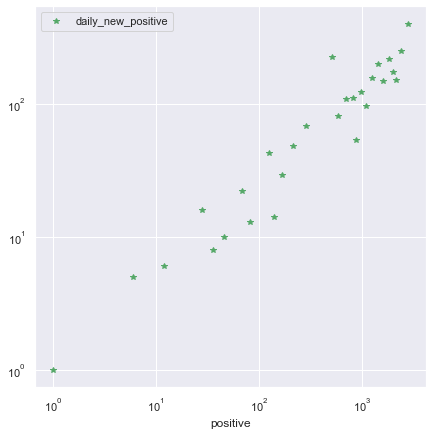

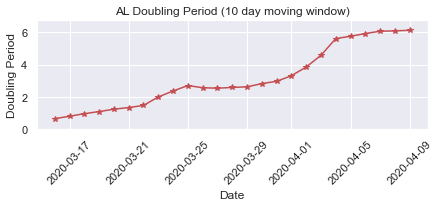

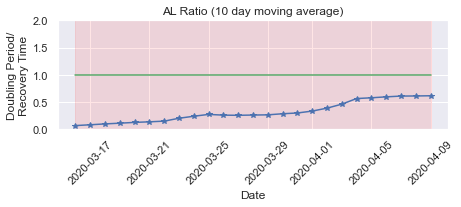

State=SC  (last_update=2020-03-04T00:00)
Doubling every 6.98 days based on last 10 days of data


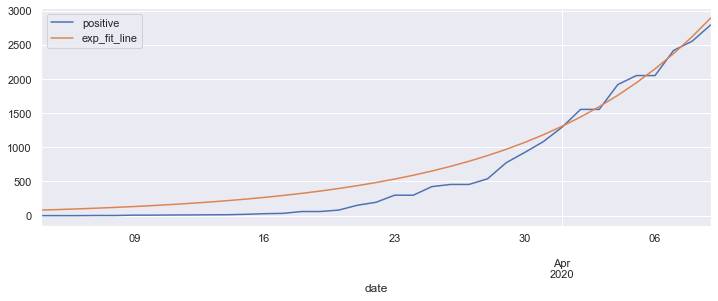

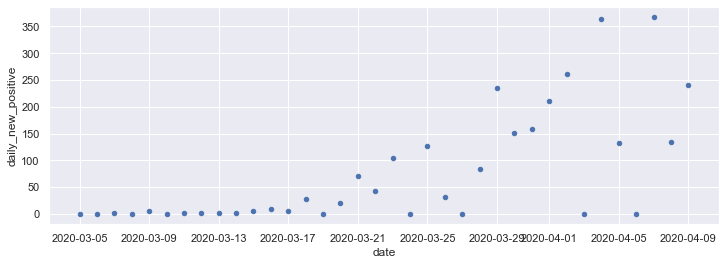

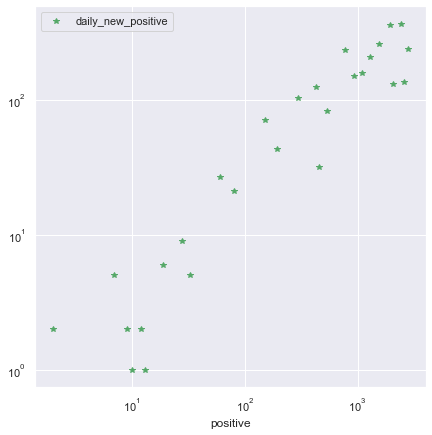

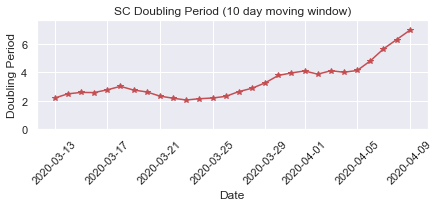

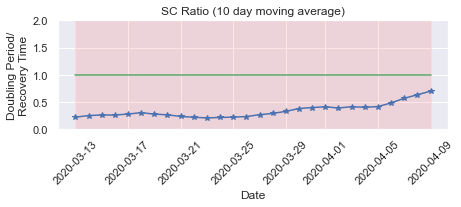

State=NV  (last_update=2020-03-05T00:00)
Doubling every 8.23 days based on last 10 days of data


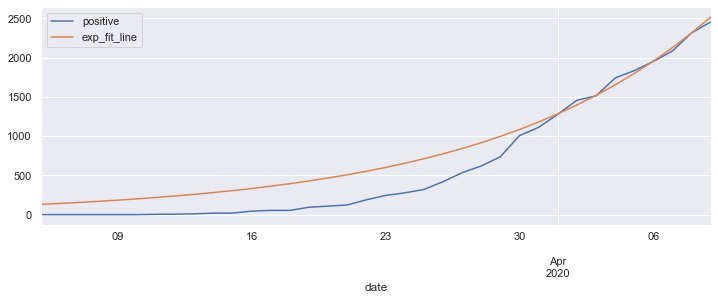

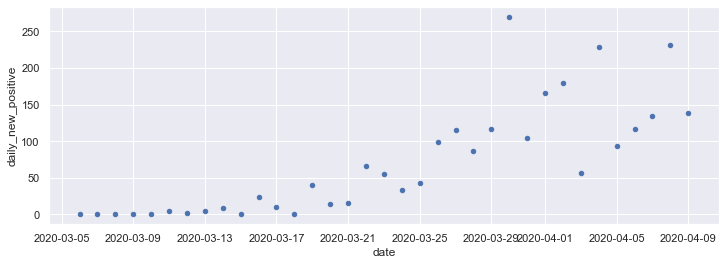

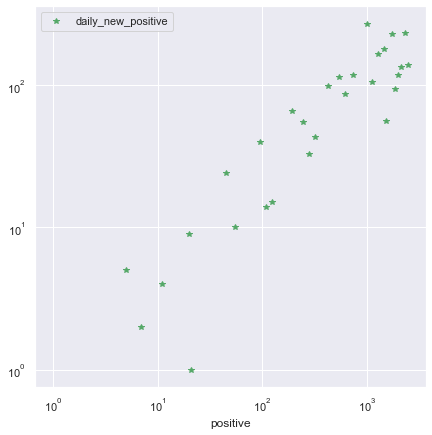

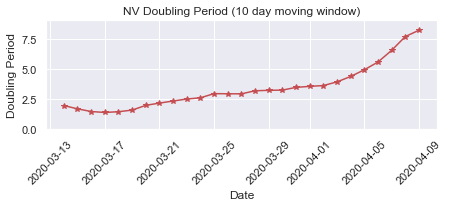

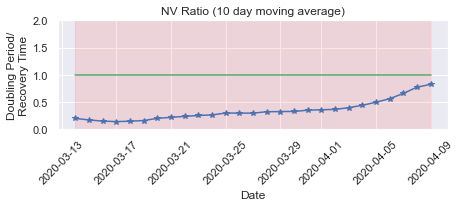

State=MS  (last_update=2020-03-07T00:00)
Doubling every 7.34 days based on last 10 days of data


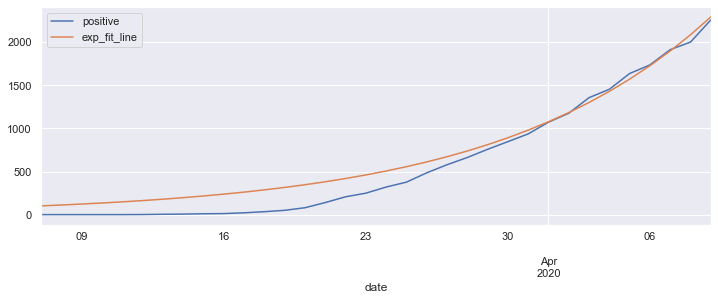

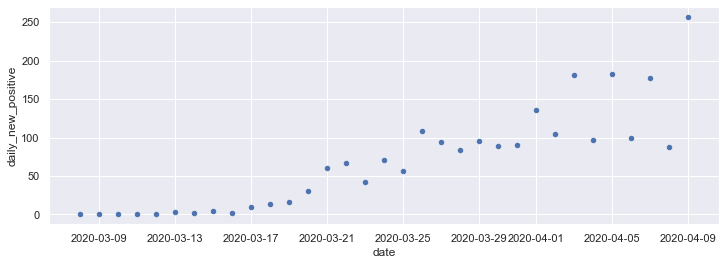

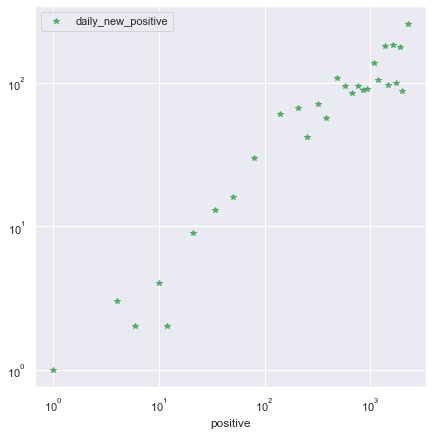

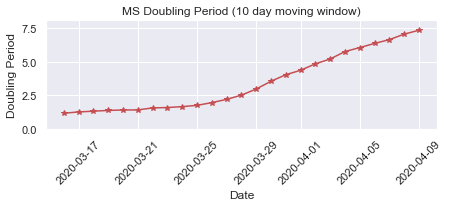

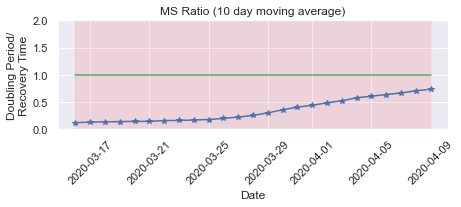

State=UT  (last_update=2020-03-07T00:00)
Doubling every 7.71 days based on last 10 days of data


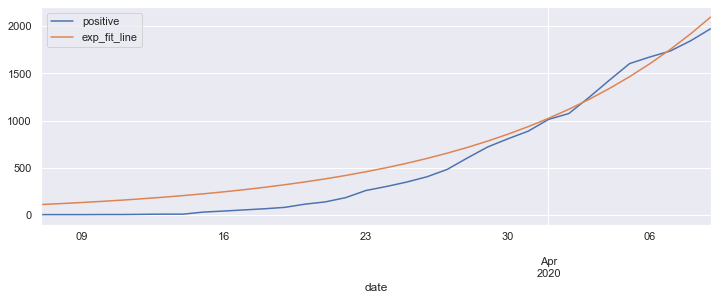

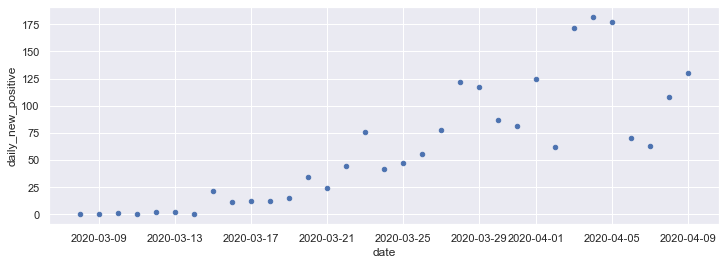

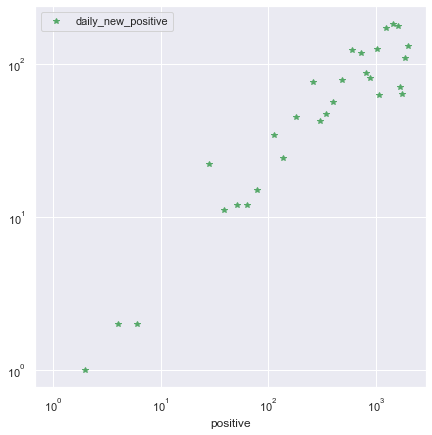

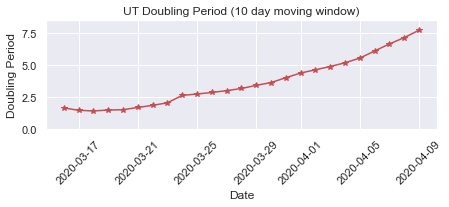

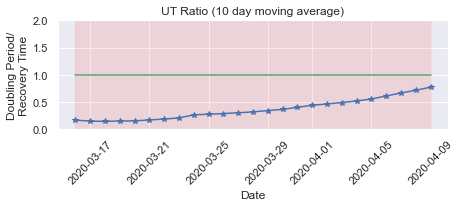

State=RI  (last_update=2020-03-01T00:00)
Doubling every 5.09 days based on last 10 days of data


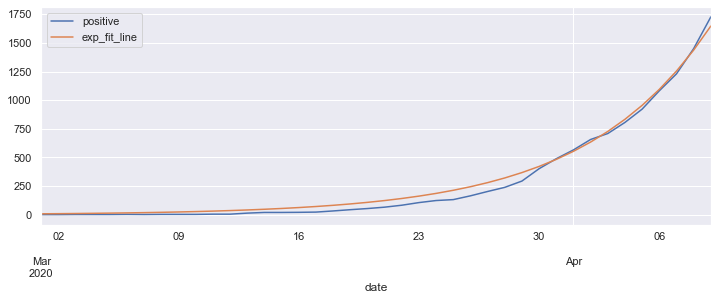

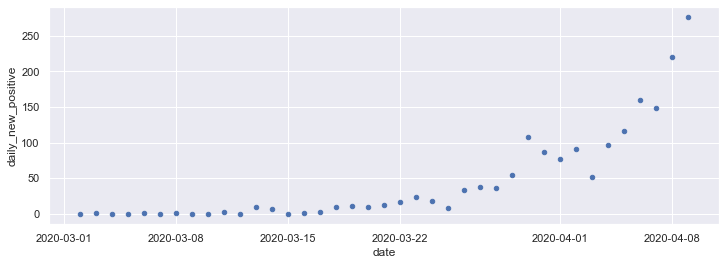

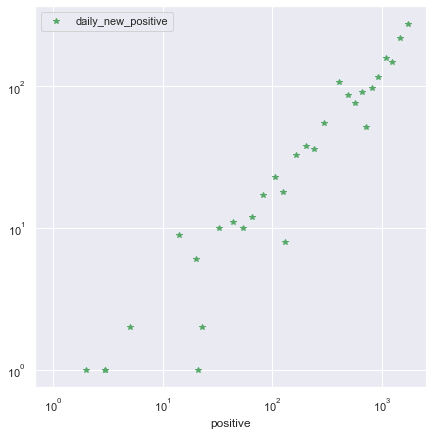

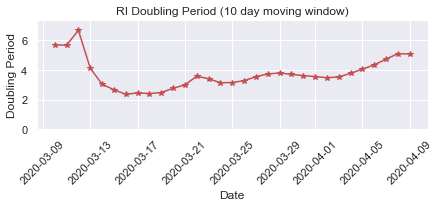

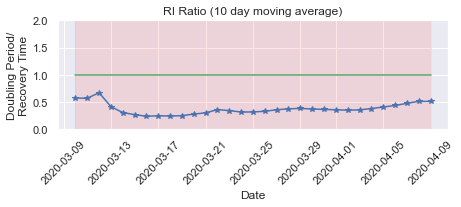

State=OK  (last_update=2020-03-07T00:00)
Doubling every 6.14 days based on last 10 days of data


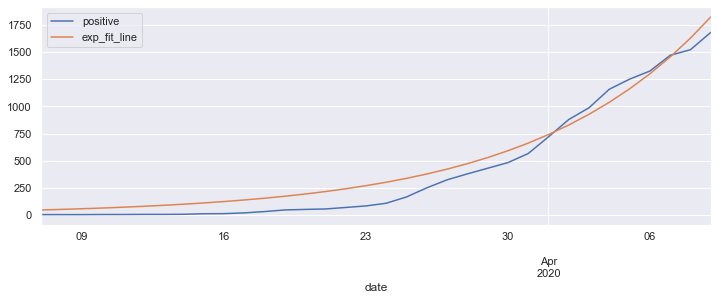

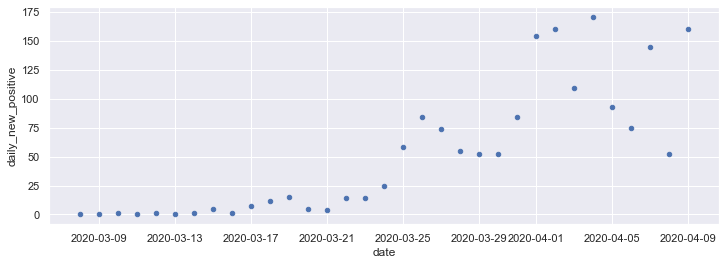

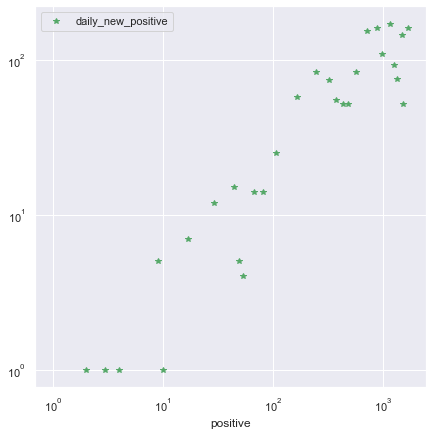

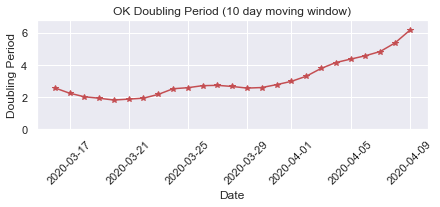

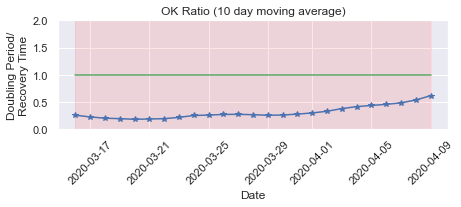

State=DC  (last_update=2020-03-05T00:00)
Doubling every 5.52 days based on last 10 days of data


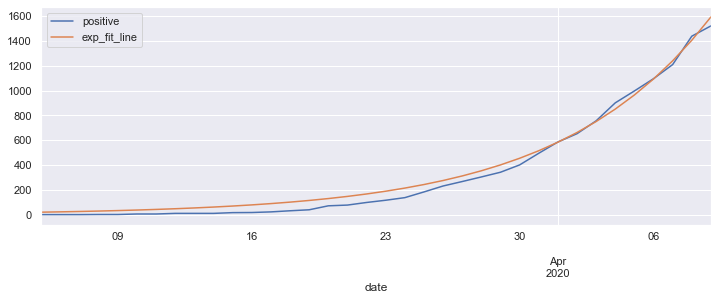

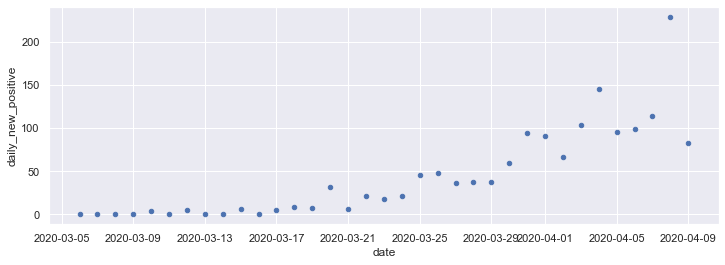

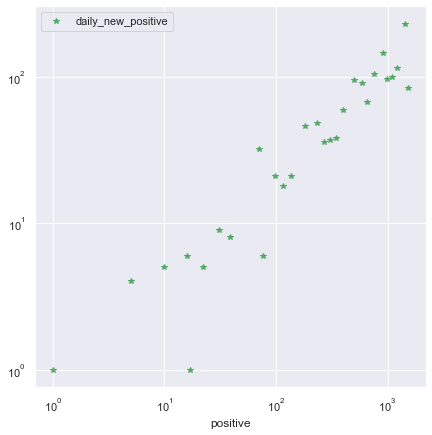

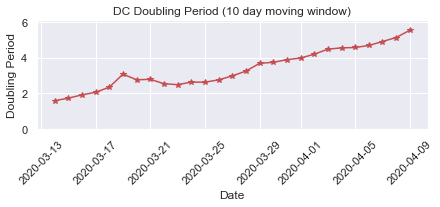

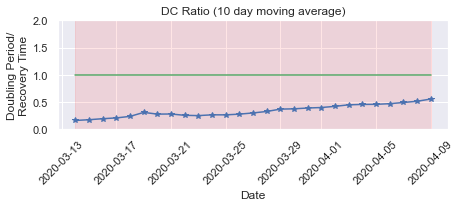

State=KY  (last_update=2020-03-06T00:00)
Doubling every 6.87 days based on last 10 days of data


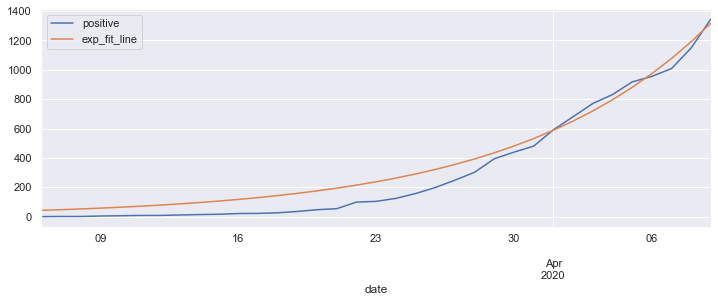

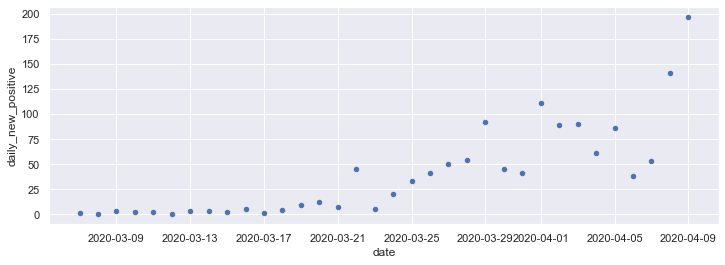

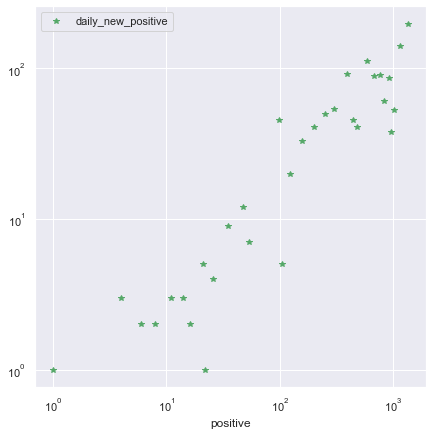

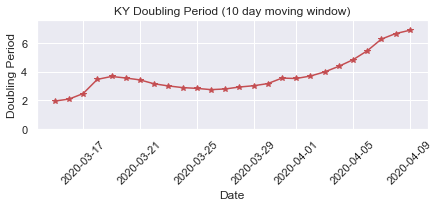

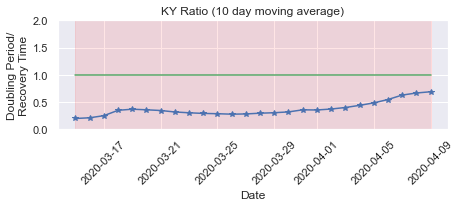

State=ID  (last_update=2020-03-07T00:00)
Doubling every 5.98 days based on last 10 days of data


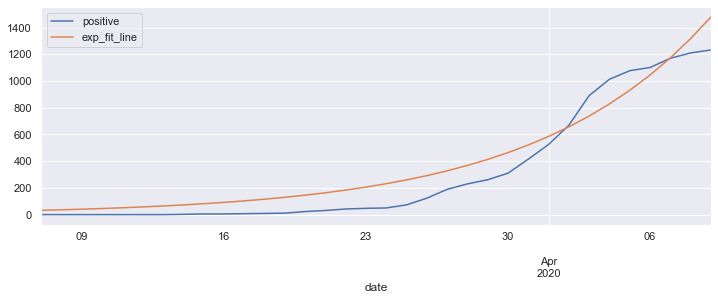

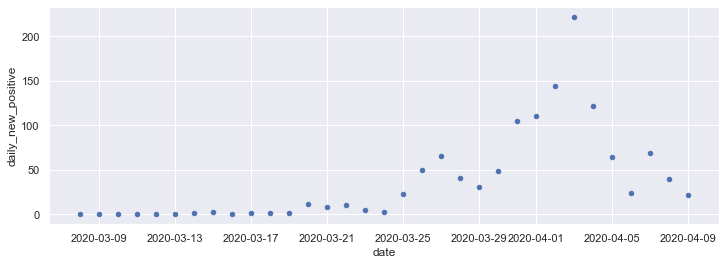

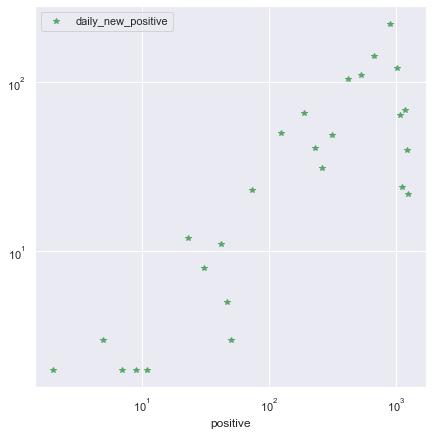

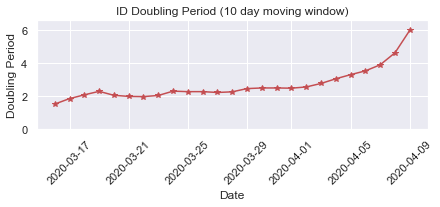

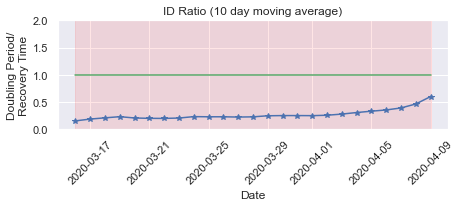

State=OR  (last_update=2020-03-04T00:00)
Doubling every 9.5 days based on last 10 days of data


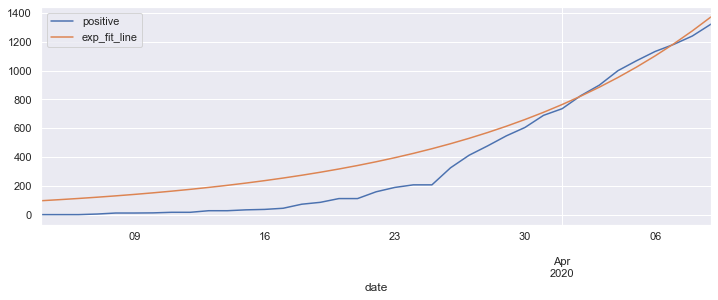

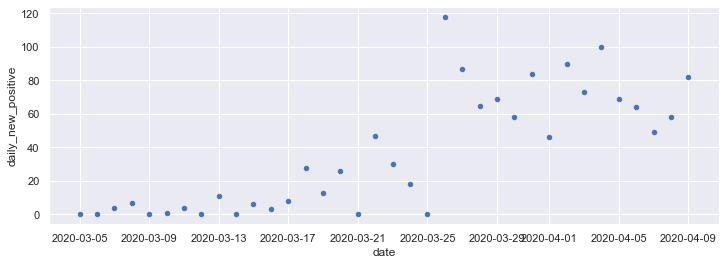

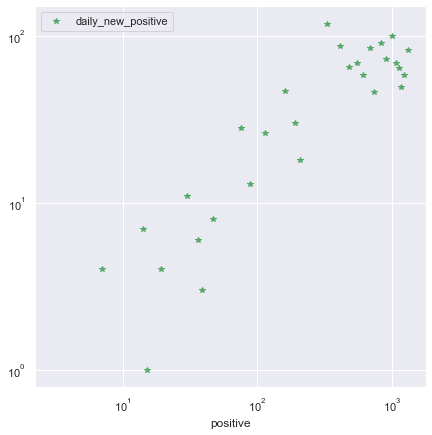

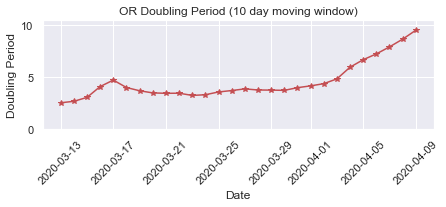

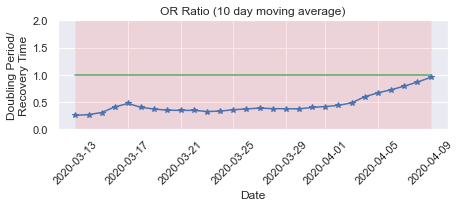

State=IA  (last_update=2020-03-06T00:00)
Doubling every 6.62 days based on last 10 days of data


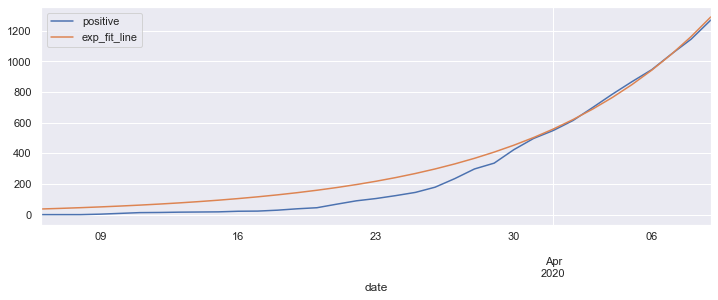

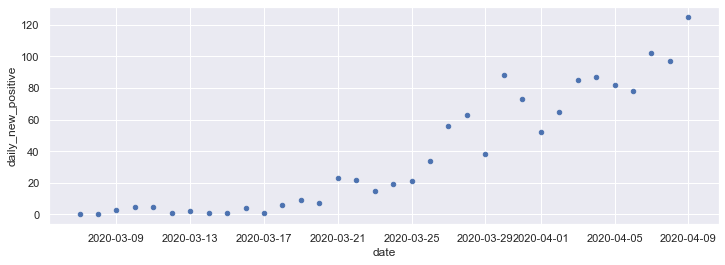

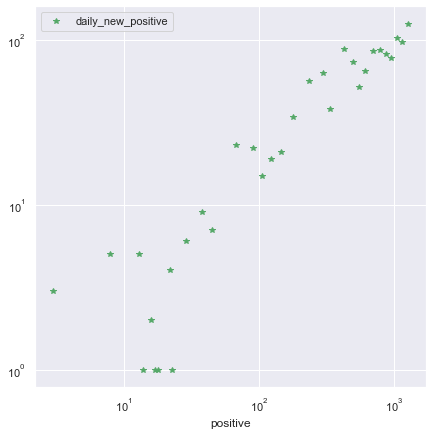

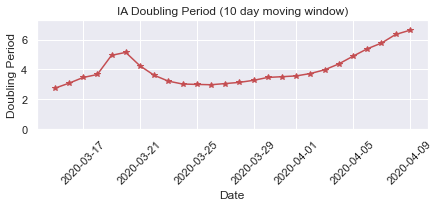

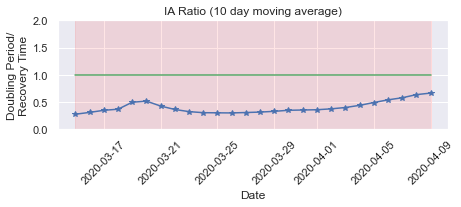

State=MN  (last_update=2020-03-06T00:00)
Doubling every 9.29 days based on last 10 days of data


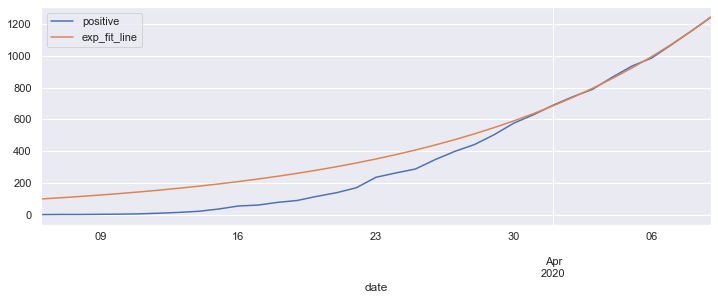

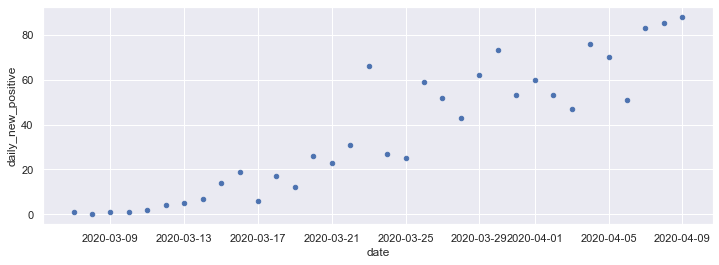

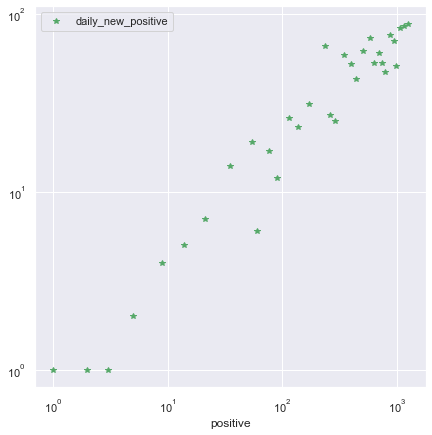

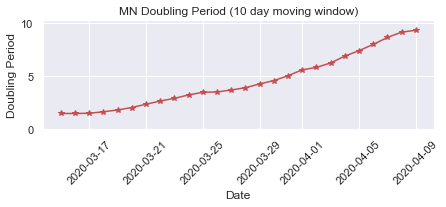

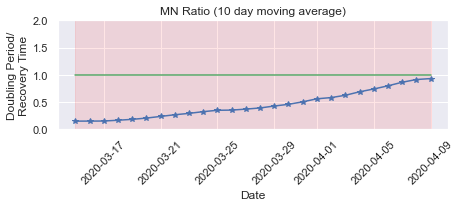

State=DE  (last_update=2020-03-06T00:00)
Doubling every 4.75 days based on last 10 days of data


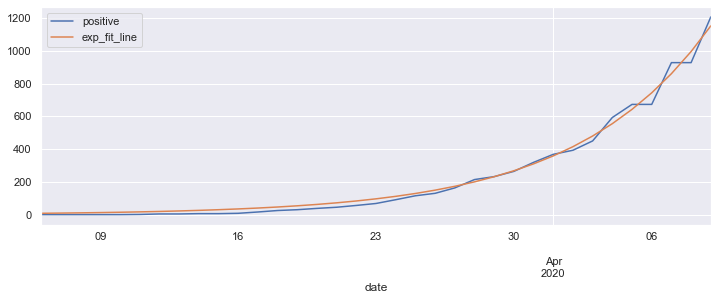

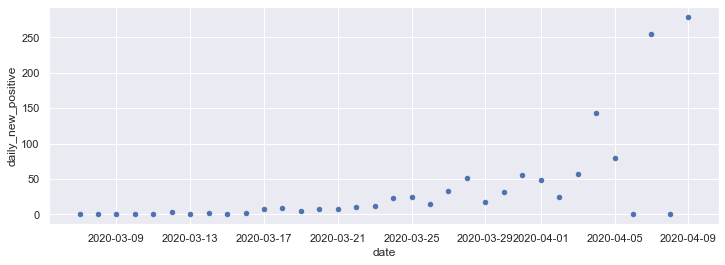

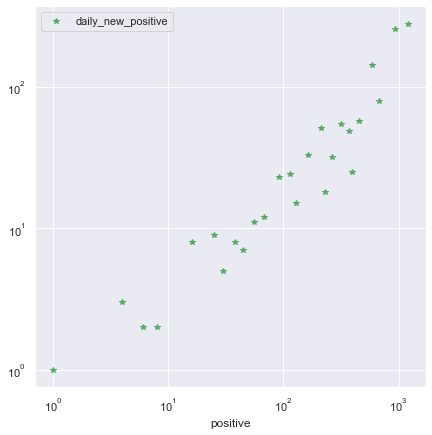

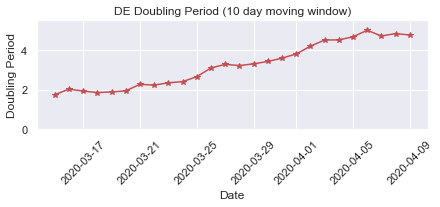

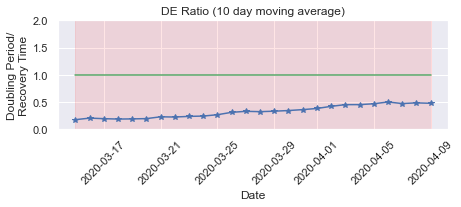

State=AR  (last_update=2020-03-06T00:00)
Doubling every 8.6 days based on last 10 days of data


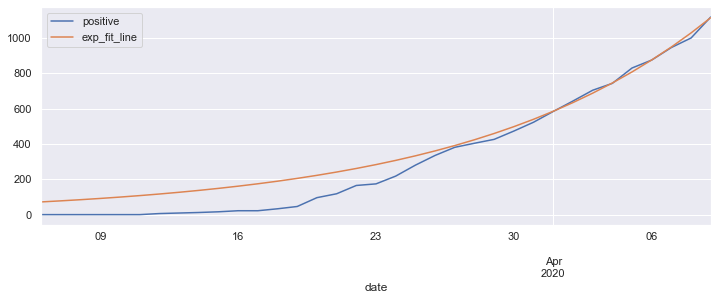

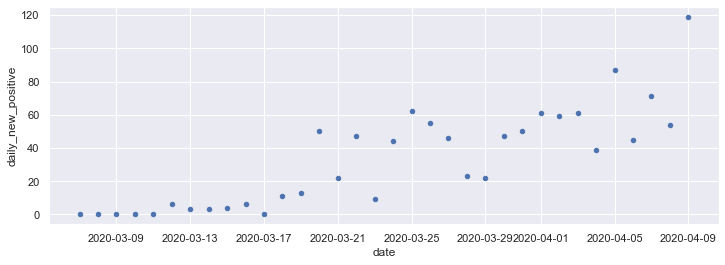

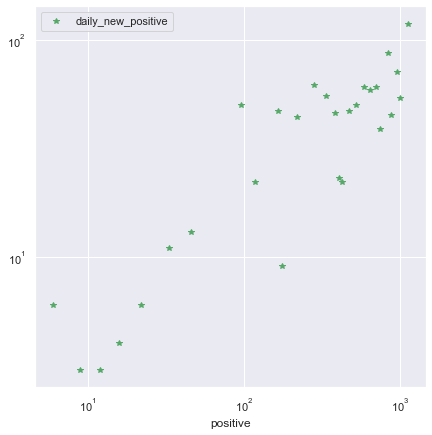

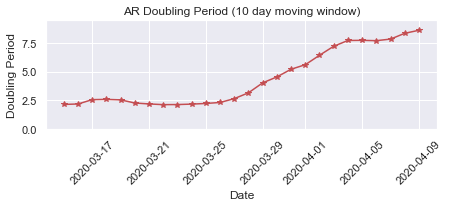

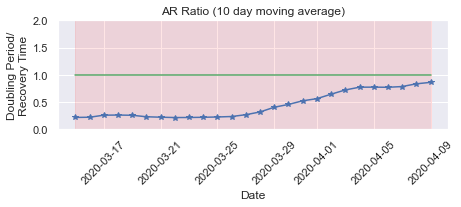

State=KS  (last_update=2020-03-06T00:00)
Doubling every 6.99 days based on last 10 days of data


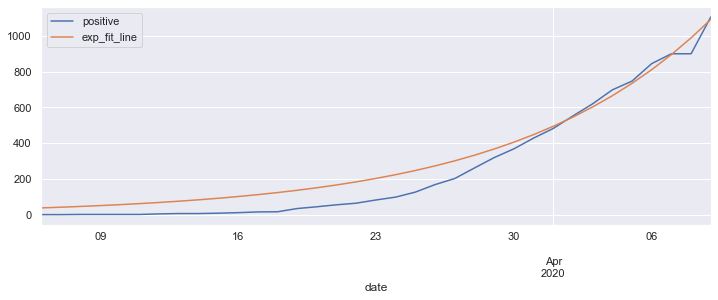

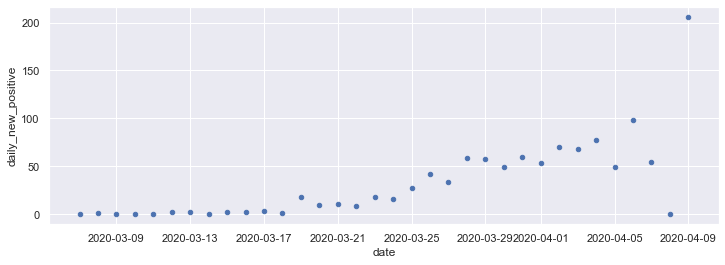

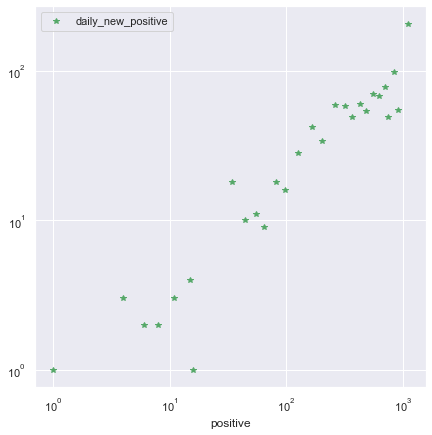

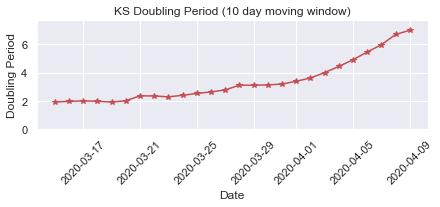

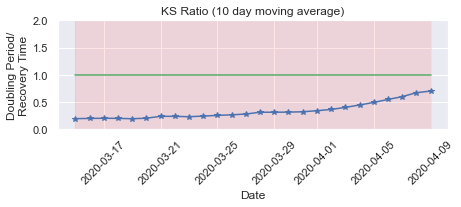

State=NM  (last_update=2020-03-06T00:00)
Doubling every 5.4 days based on last 10 days of data


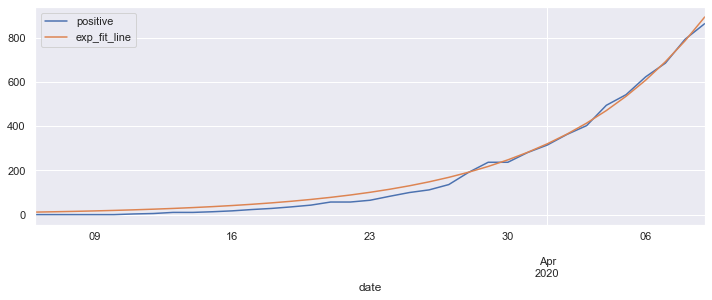

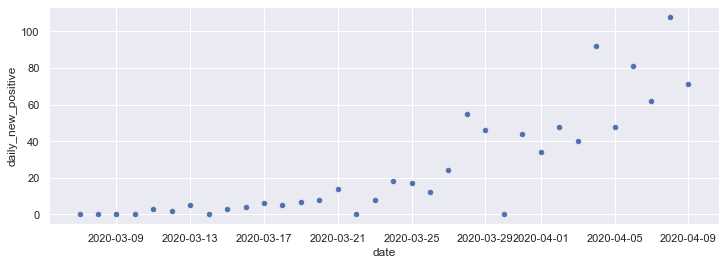

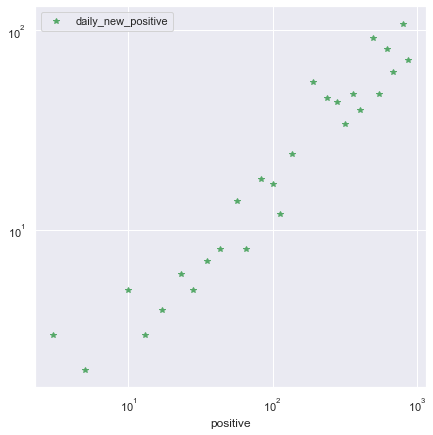

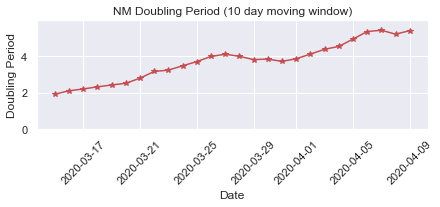

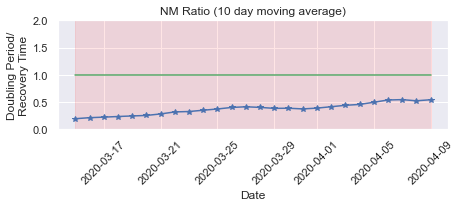

State=NH  (last_update=2020-03-04T00:00)
Doubling every 6.88 days based on last 10 days of data


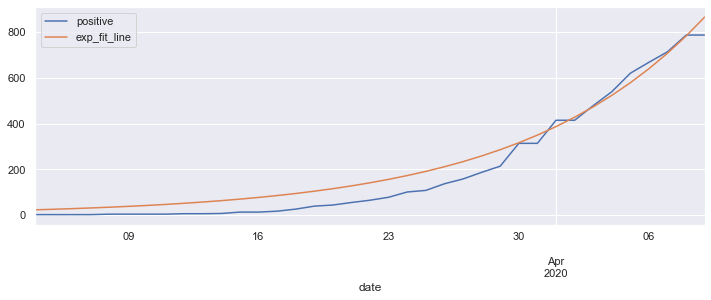

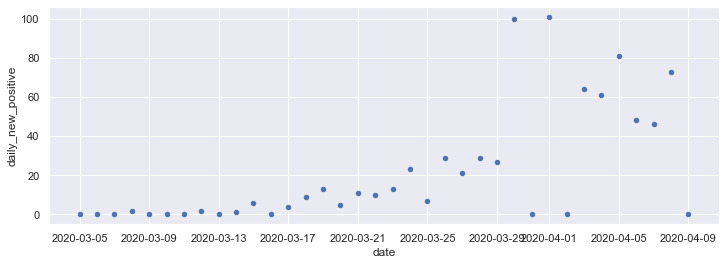

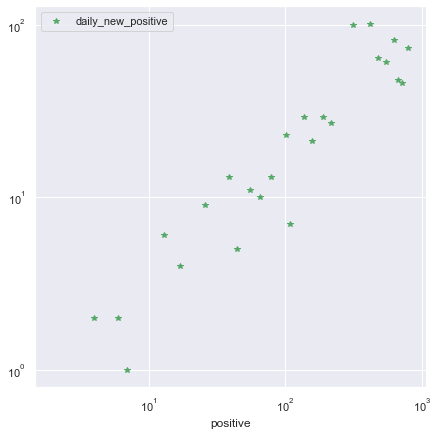

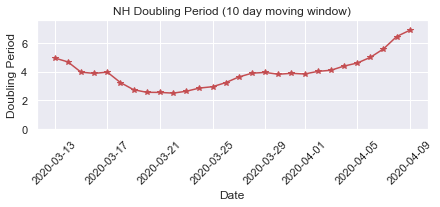

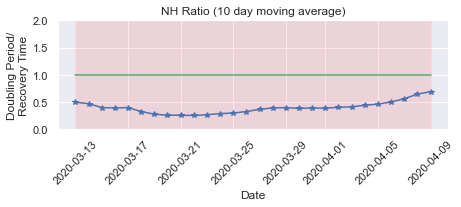

State=PR  (last_update=2020-03-16T00:00)
Doubling every 6.08 days based on last 10 days of data


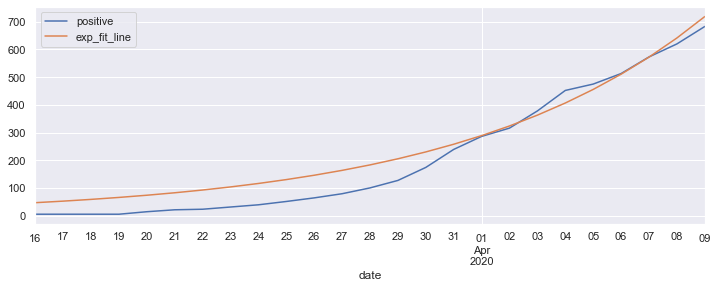

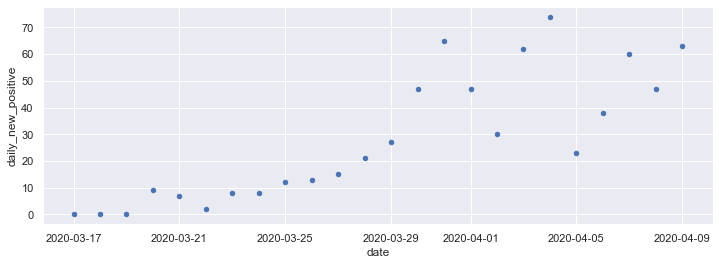

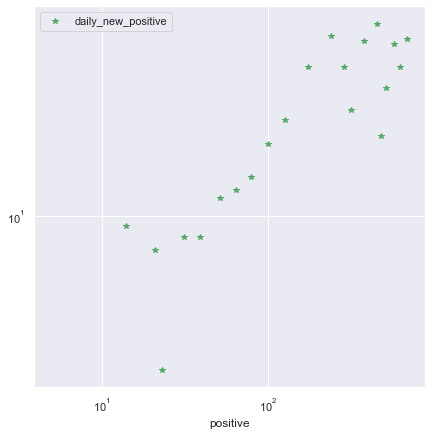

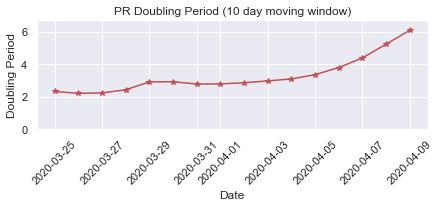

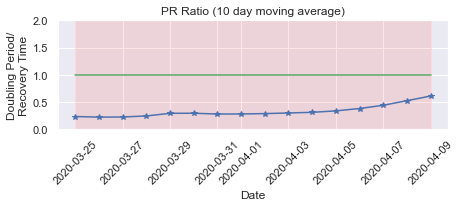

State=VT  (last_update=2020-03-06T00:00)
Doubling every 7.59 days based on last 10 days of data


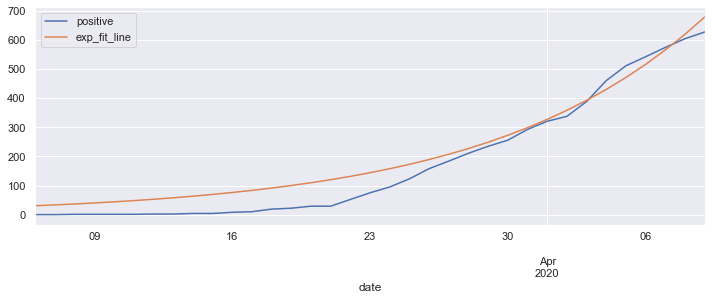

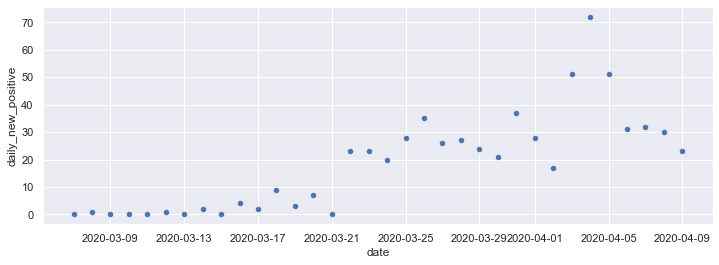

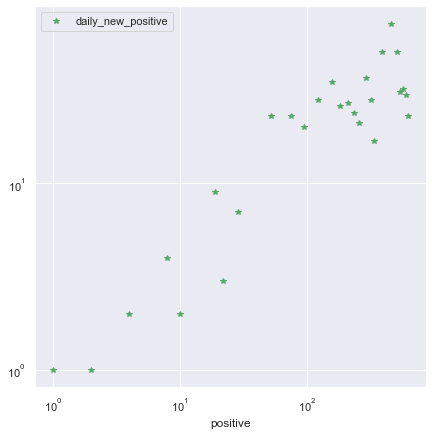

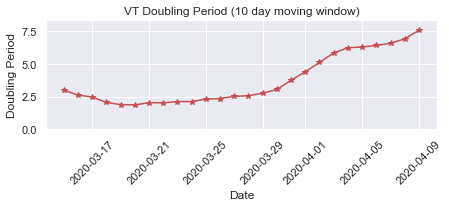

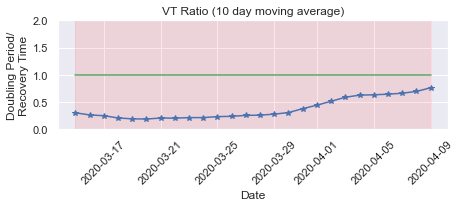

State=NE  (last_update=2020-03-05T00:00)
Doubling every 5.36 days based on last 10 days of data


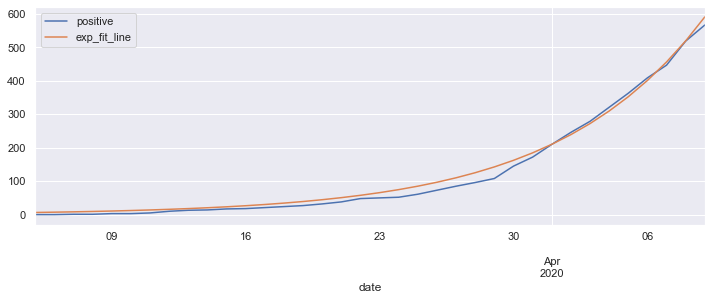

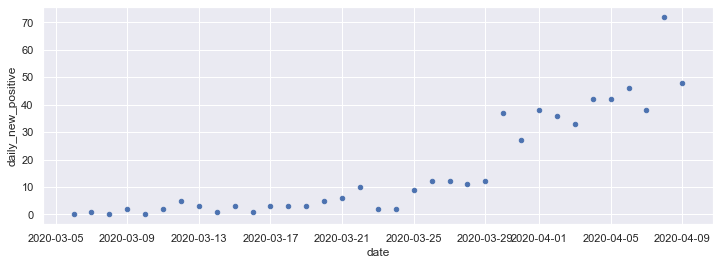

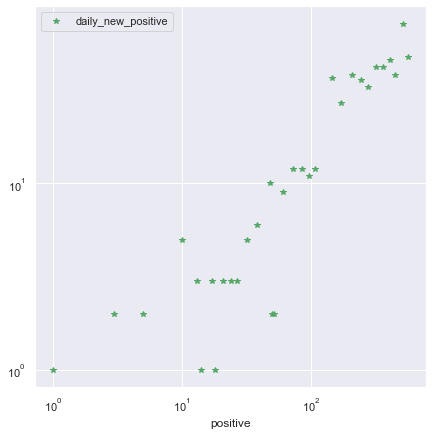

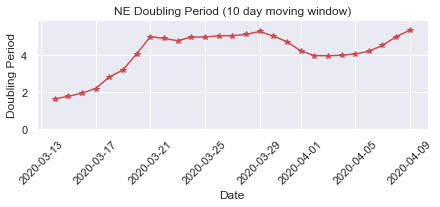

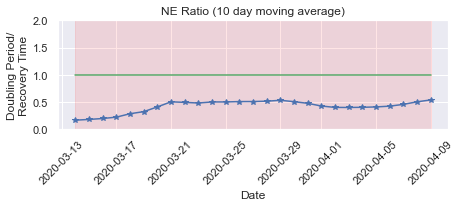

State=ME  (last_update=2020-03-07T00:00)
Doubling every 10.7 days based on last 10 days of data


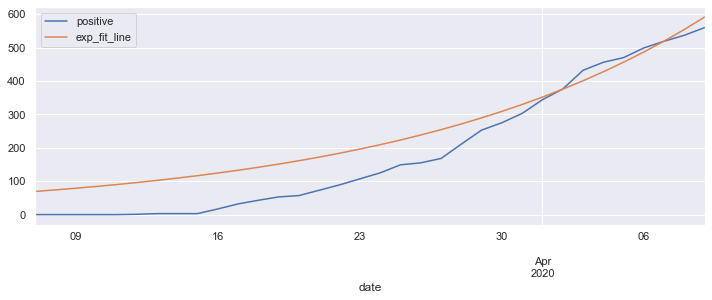

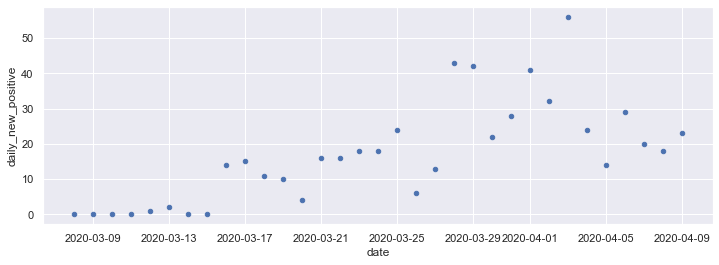

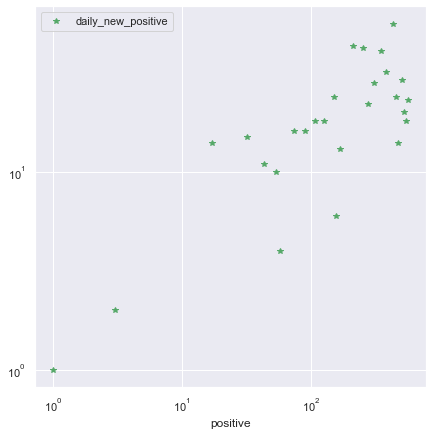

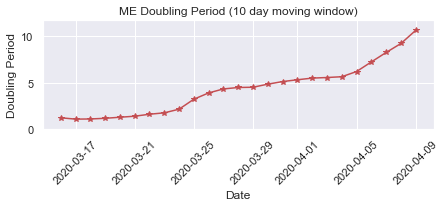

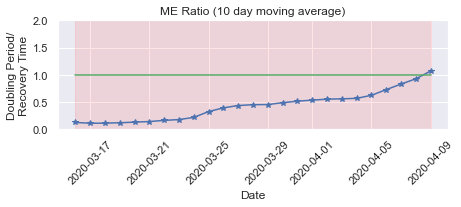

State=WV  (last_update=2020-03-06T00:00)
Doubling every 5.39 days based on last 10 days of data


/Users/drskippy/Working/2020covid19/covid_analysis/models.py:50: RuntimeWarning: divide by zero encountered in double_scalars
  return -np.log(.5)/m, fit_line_points, (m, b)


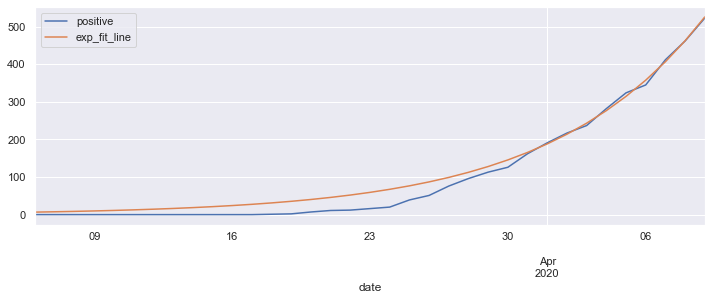

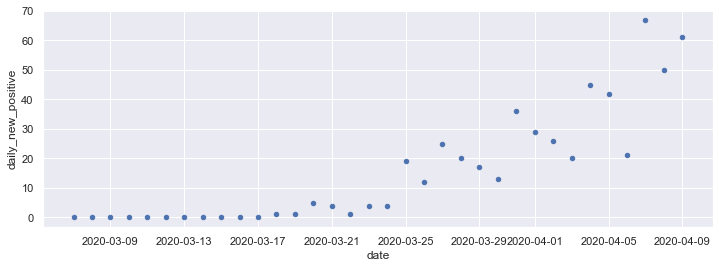

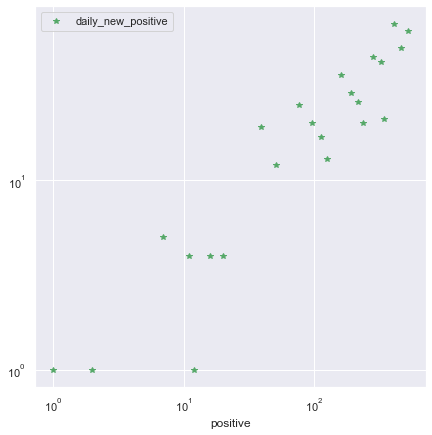

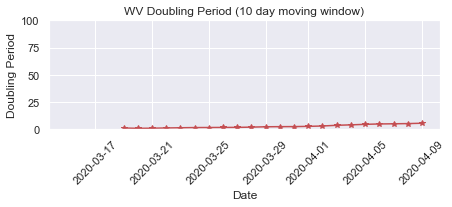

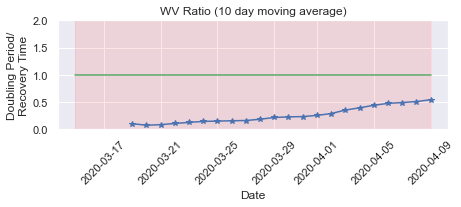

State=SD  (last_update=2020-03-07T00:00)
Doubling every 4.52 days based on last 10 days of data


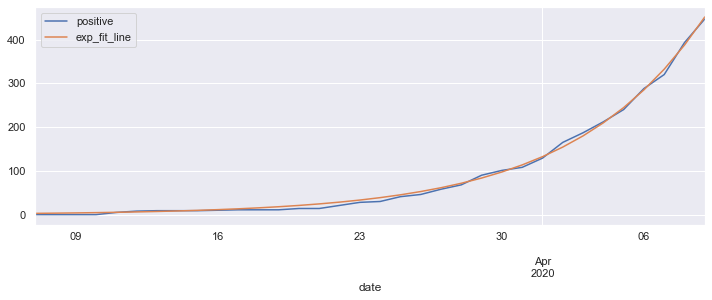

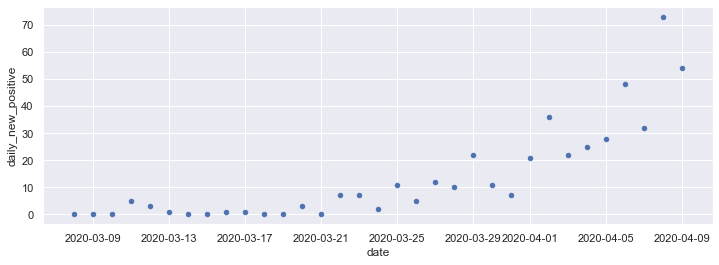

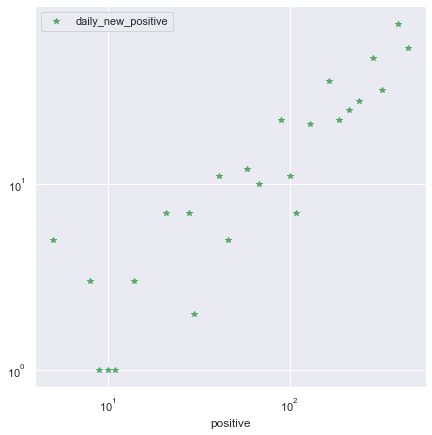

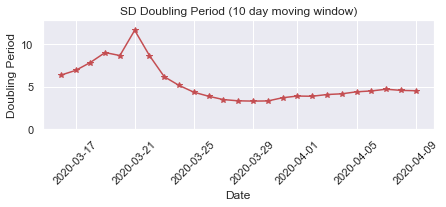

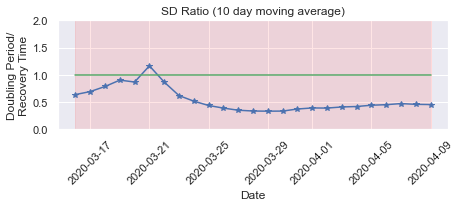

State=HI  (last_update=2020-03-07T00:00)
Doubling every 7.9 days based on last 10 days of data


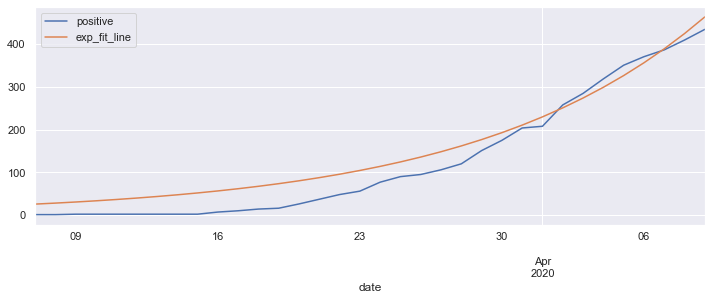

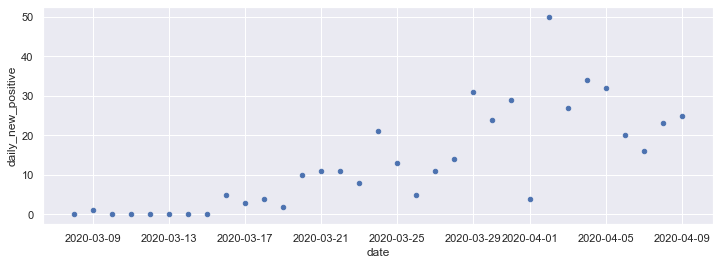

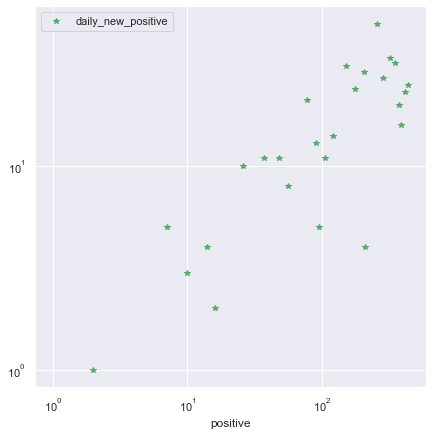

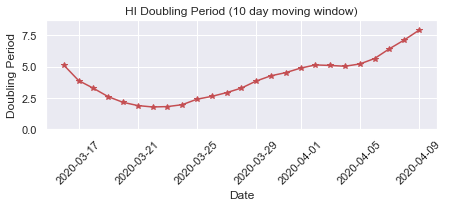

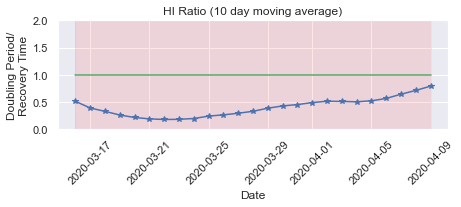

State=MT  (last_update=2020-03-07T00:00)
Doubling every 9.89 days based on last 10 days of data


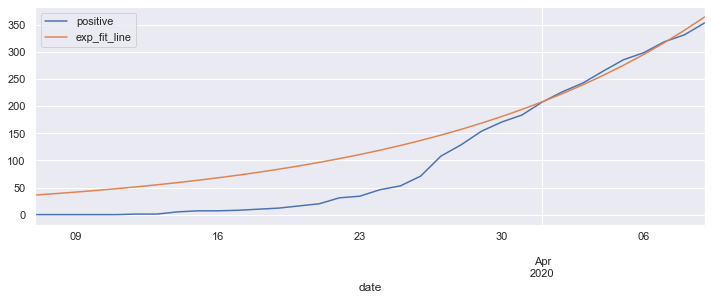

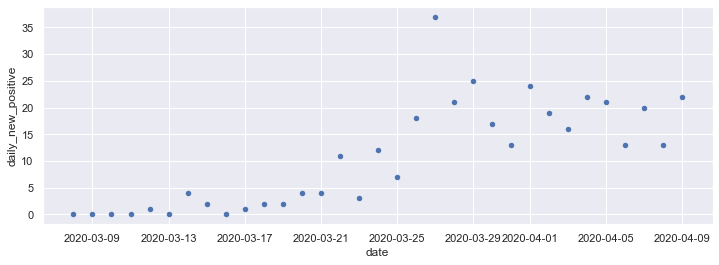

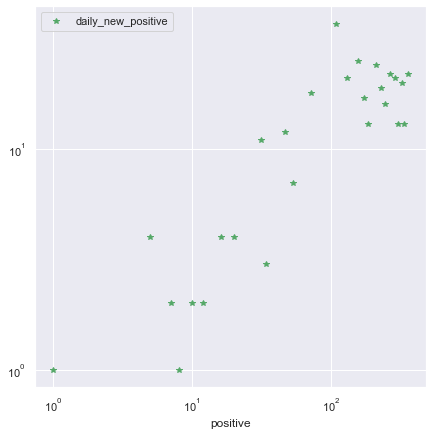

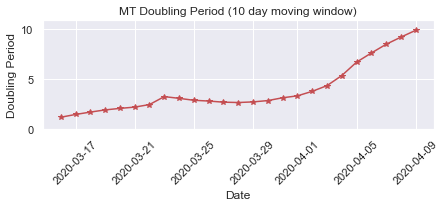

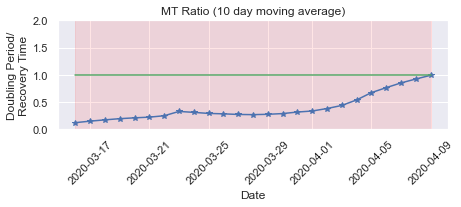

State=ND  (last_update=2020-03-07T00:00)
Doubling every 8.35 days based on last 10 days of data


/Users/drskippy/Working/2020covid19/covid_analysis/models.py:50: RuntimeWarning: divide by zero encountered in double_scalars
  return -np.log(.5)/m, fit_line_points, (m, b)


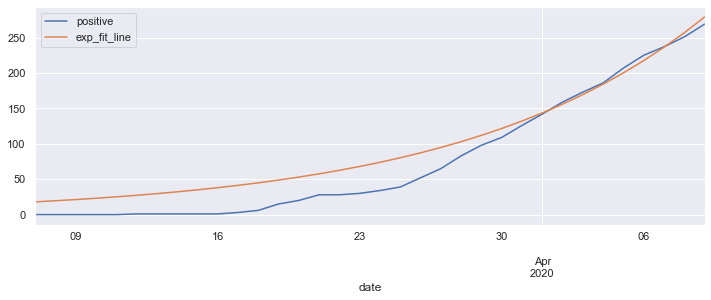

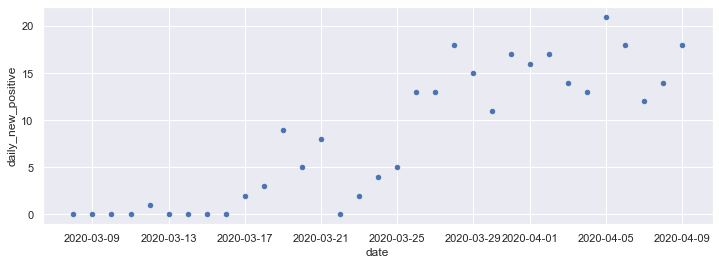

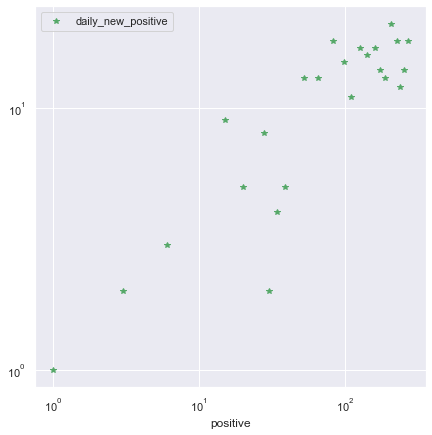

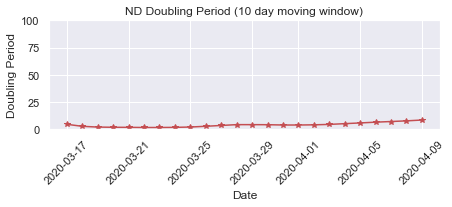

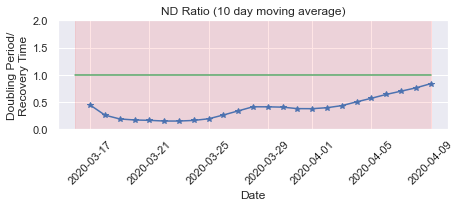

State=WY  (last_update=2020-03-07T00:00)
Doubling every 8.74 days based on last 10 days of data


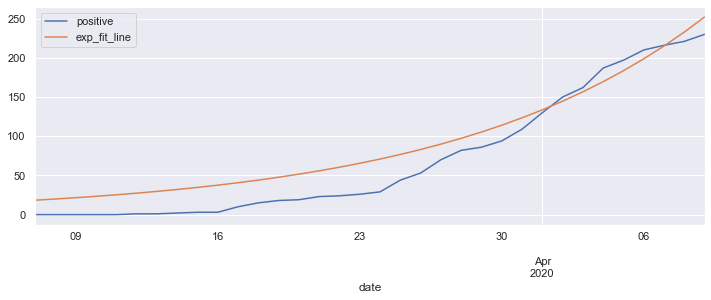

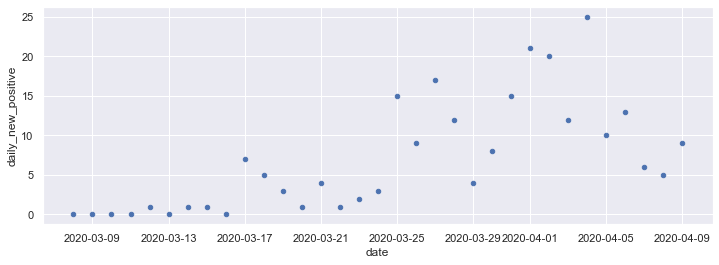

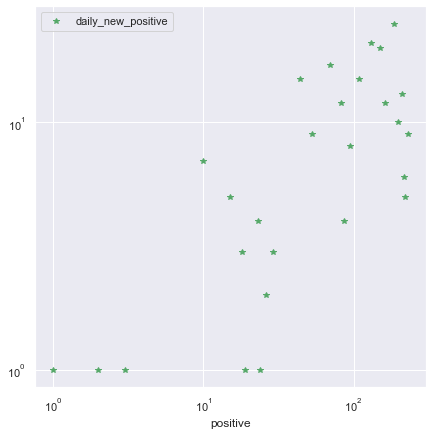

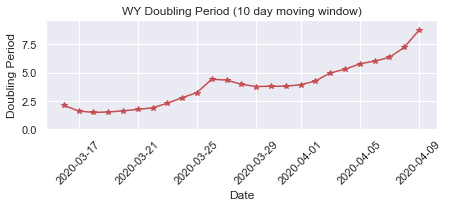

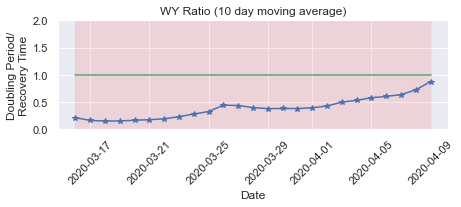

State=AK  (last_update=2020-03-06T00:00)
Doubling every 9.15 days based on last 10 days of data


/Users/drskippy/Working/2020covid19/covid_analysis/models.py:50: RuntimeWarning: divide by zero encountered in double_scalars
  return -np.log(.5)/m, fit_line_points, (m, b)


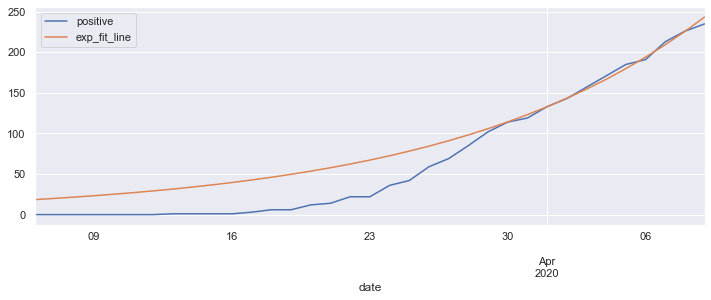

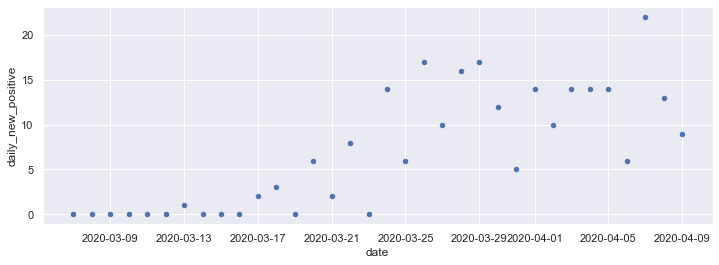

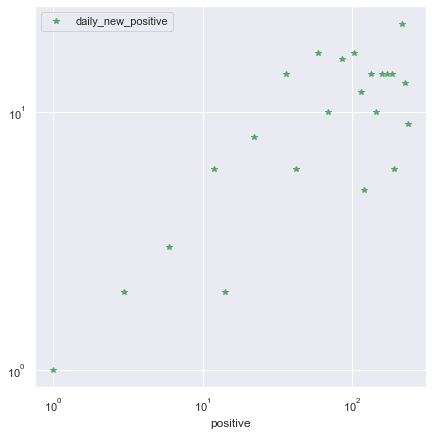

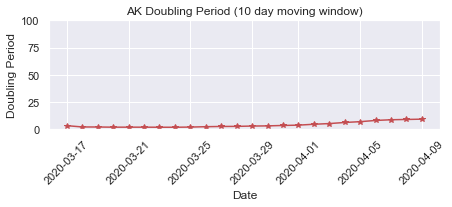

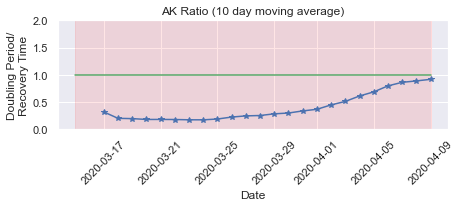

State=GU  (last_update=2020-03-16T00:00)
Doubling every 9.55 days based on last 10 days of data


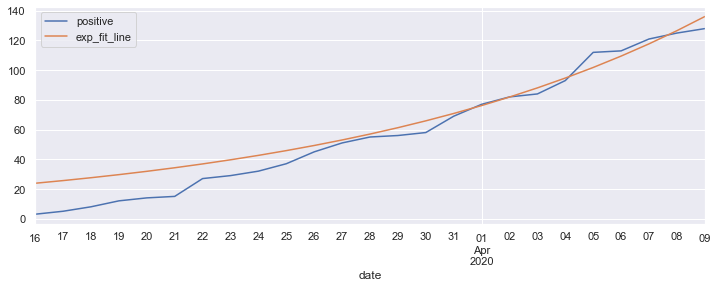

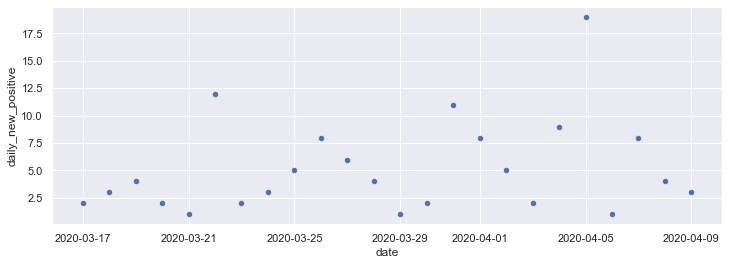

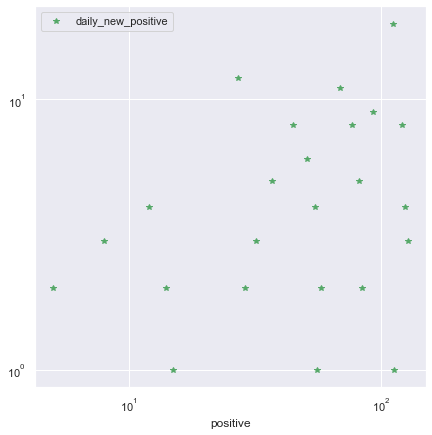

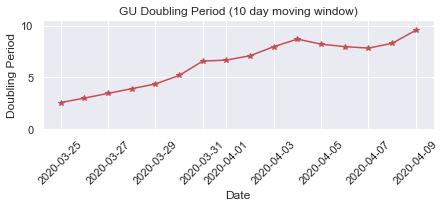

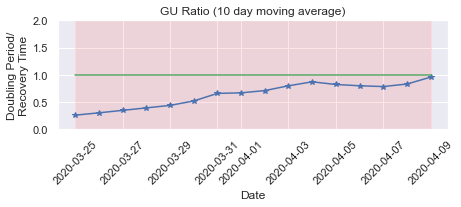

State=VI  (last_update=2020-03-16T00:00)
Doubling every 13.6 days based on last 10 days of data


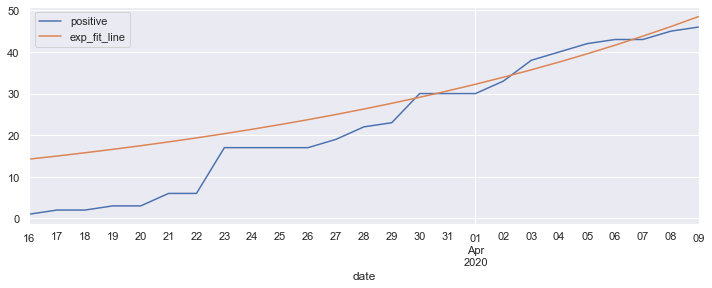

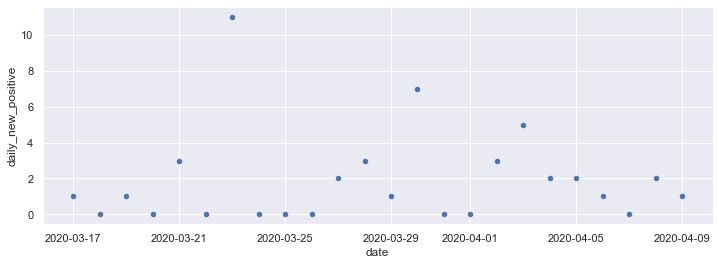

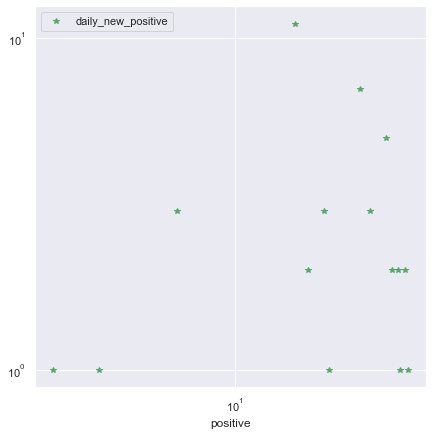

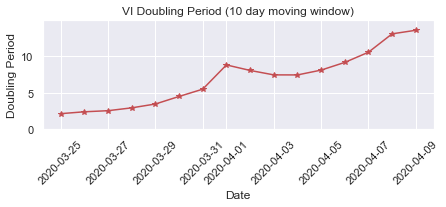

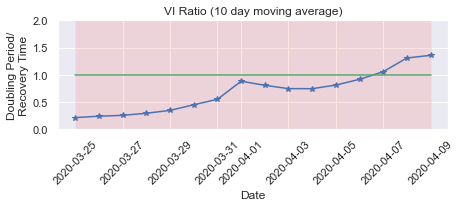

State=MP  (last_update=2020-03-16T00:00)
Doubling every 5.84 days based on last 10 days of data


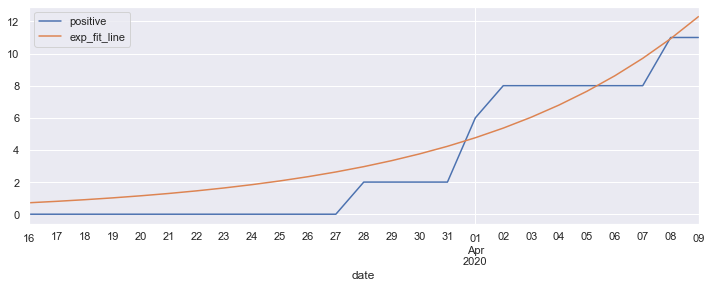

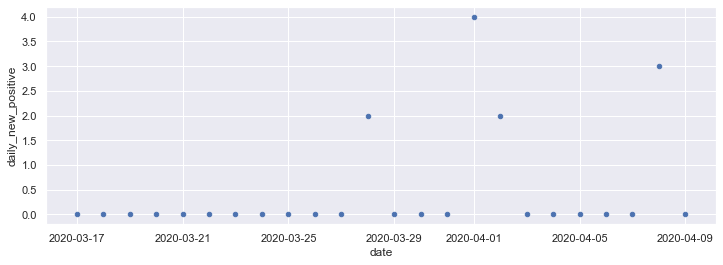

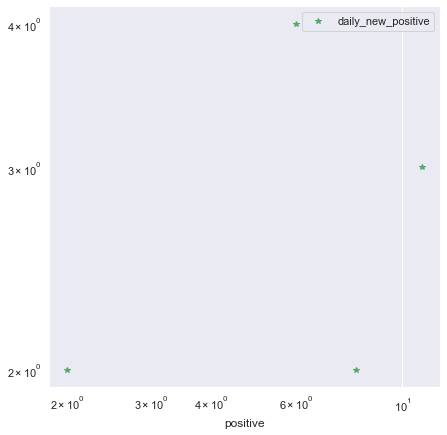

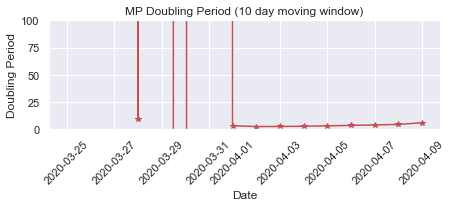

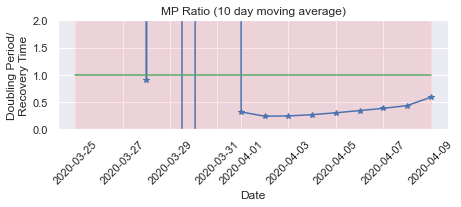

State=AS  (last_update=2020-03-16T00:00)
Doubling every nan days based on last 10 days of data


/Users/drskippy/Library/Caches/pypoetry/virtualenvs/covid19-r4Mn4VDy-py3.8/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:520: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  labels = axis.get_majorticklabels() + axis.get_minorticklabels()


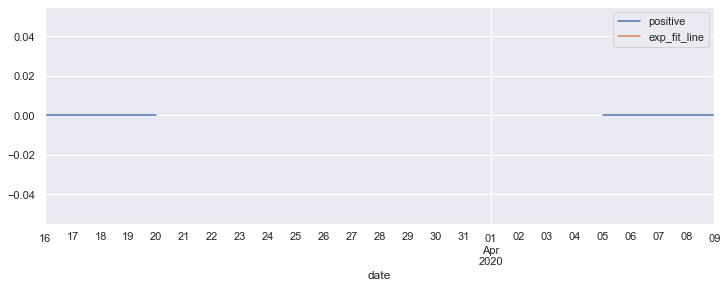

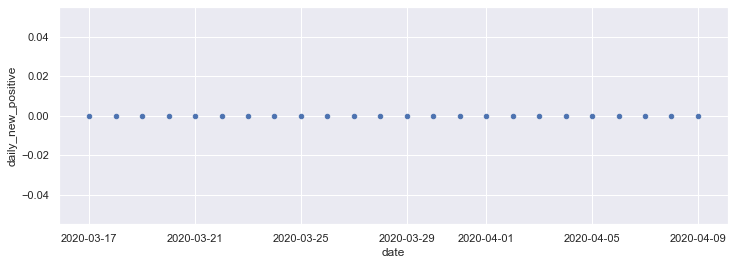

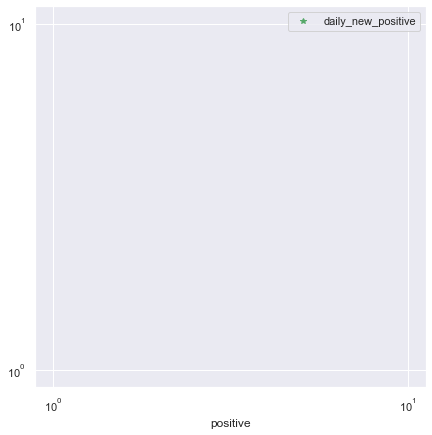

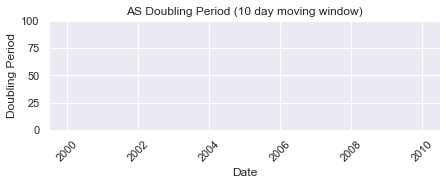

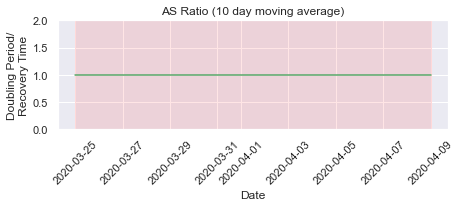

In [13]:
last_n_days = 10
dps = []
for s in states_in_order:
    dfq, dt, _ = get_state_doubling_df(df, s, use_last_n_days=last_n_days)
    dps.append(dt)
    lu = str(dfq.date.values[0])[:16]
    print("State={}  (last_update={})".format(s, lu))
    print("Doubling every {:.3} days based on last {} days of data".format(dt, last_n_days))
    dfq.plot(x="date", y=["positive", "exp_fit_line"], figsize=[12,4])
    if len(dfq) > 1:
        dfq.plot.scatter(x="date", y="daily_new_positive", figsize=[12,4])
    dfq.plot(x="positive", y="daily_new_positive", figsize=[7,7], style="*g", logy=True, logx=True)
    period_factor_plot(dfq,s, ylimit=2)
    plt.show()

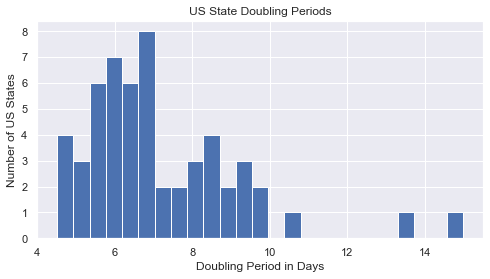

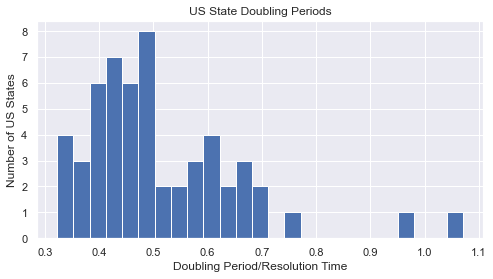

In [14]:
plt.figure(figsize=[8,4])
dps = np.array(dps)
dps = dps[~np.isnan(dps)]
dp_state = dps[dps < 30]
dp_state = dp_state[dp_state > 0]
a = plt.hist(dp_state, bins=25)
plt.title("US State Doubling Periods")
plt.xlabel("Doubling Period in Days")
plt.ylabel("Number of US States")
plt.show()
# or in terms of resolution time
plt.figure(figsize=[8,4])
resolution_time = 14
a = plt.hist(dp_state/resolution_time, bins=25)
plt.title("US State Doubling Periods")
plt.xlabel("Doubling Period/Resolution Time")
plt.ylabel("Number of US States")
plt.show()

### Rolling Doubling Period World

In [15]:
dfw, cl = get_dataset_df_from_files()
dfw.head()
print(dfw.columns)

Index(['Entity', 'state', 'Date', 'positive', 'death', 'daily_new_death',
       'date', 'last_update', 'daily_new_positive'],
      dtype='object')


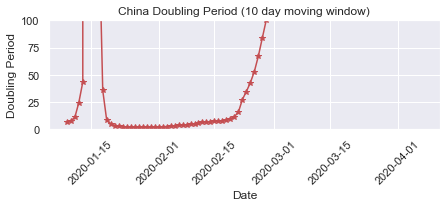

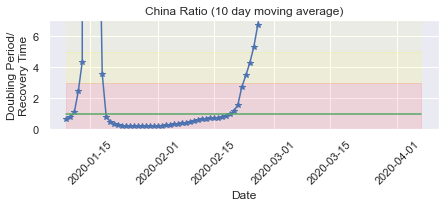

/Users/drskippy/Working/2020covid19/covid_analysis/models.py:50: RuntimeWarning: divide by zero encountered in double_scalars
  return -np.log(.5)/m, fit_line_points, (m, b)


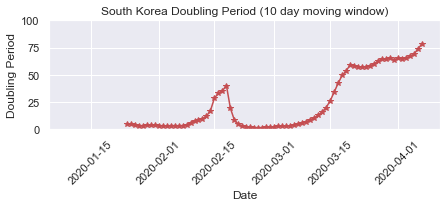

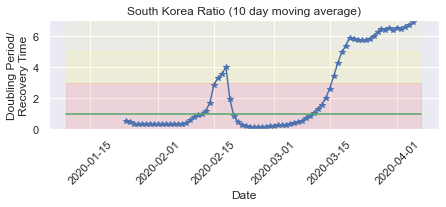

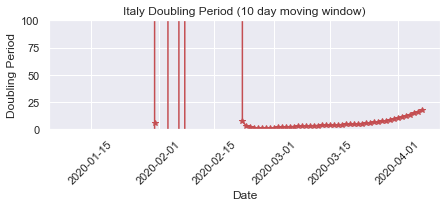

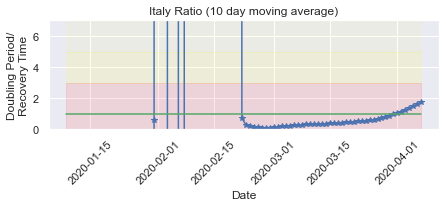

/Users/drskippy/Working/2020covid19/covid_analysis/models.py:50: RuntimeWarning: divide by zero encountered in double_scalars
  return -np.log(.5)/m, fit_line_points, (m, b)


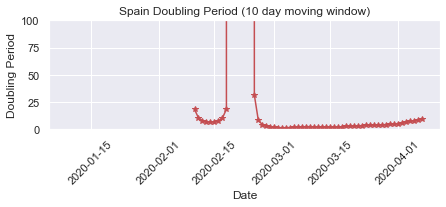

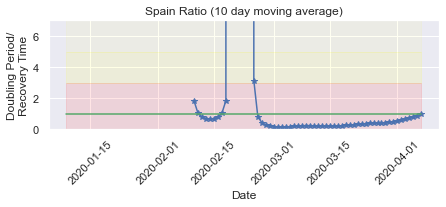

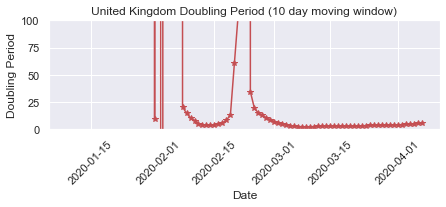

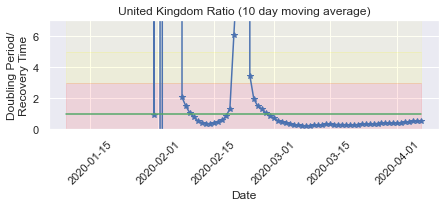

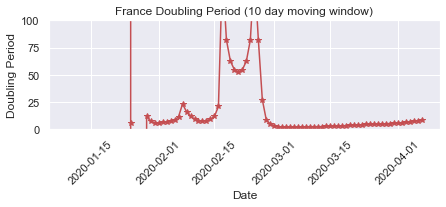

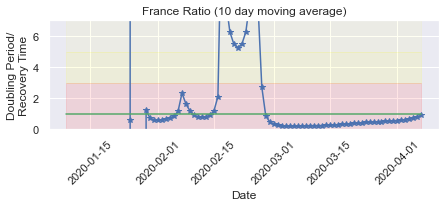

/Users/drskippy/Working/2020covid19/covid_analysis/models.py:50: RuntimeWarning: divide by zero encountered in double_scalars
  return -np.log(.5)/m, fit_line_points, (m, b)


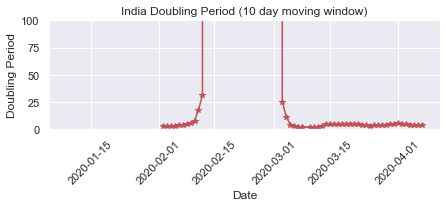

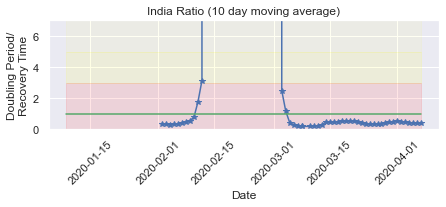

In [16]:
period_factor_plot(dfw,"CHN")
period_factor_plot(dfw,"KOR")
period_factor_plot(dfw,"ITA")
period_factor_plot(dfw,"ESP")
period_factor_plot(dfw,"GBR")
period_factor_plot(dfw,"FRA")
period_factor_plot(dfw,"IND")

### Rolling Doubling Period States

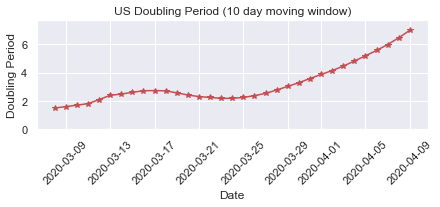

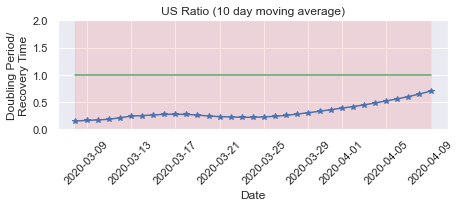

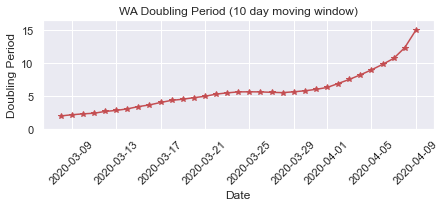

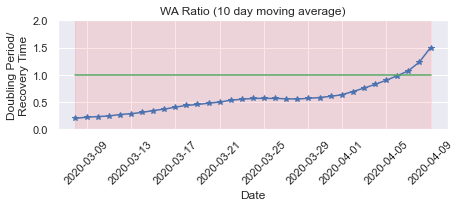

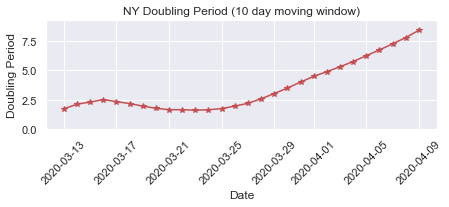

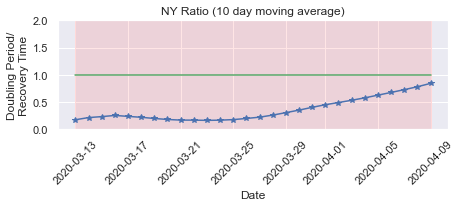

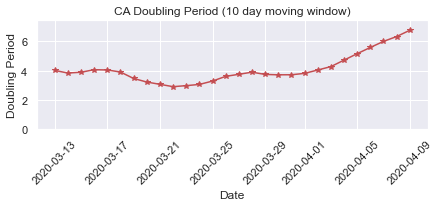

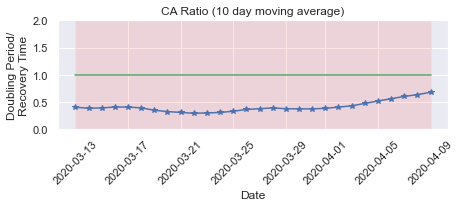

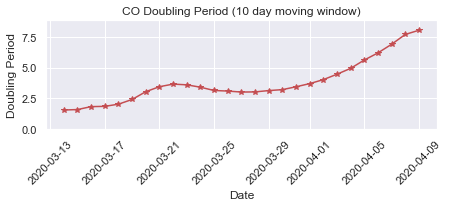

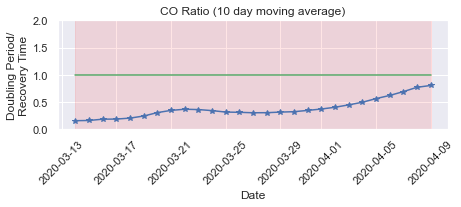

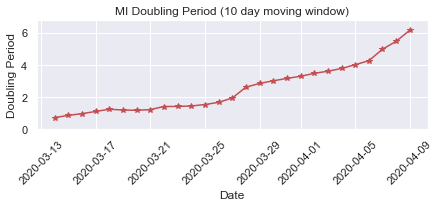

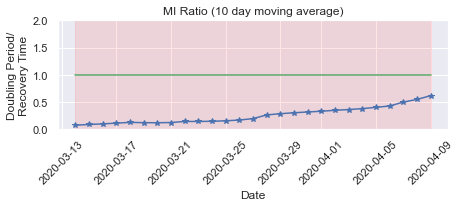

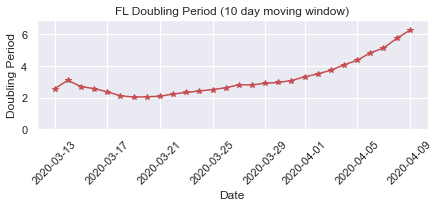

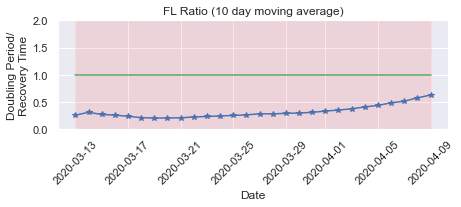

In [17]:
dfw = get_state_df(df, "*")
period_factor_plot(dfw,"*", ylimit=2)
dfw = get_state_df(df, "WA")
period_factor_plot(dfw,"WA", ylimit=2)
dfw = get_state_df(df, "NY")
period_factor_plot(dfw,"NY", ylimit=2)
dfw = get_state_df(df, "CA")
period_factor_plot(dfw,"CA", ylimit=2)
dfw = get_state_df(df, "CO")
period_factor_plot(dfw,"CO", ylimit=2)
dfw = get_state_df(df, "MI")
period_factor_plot(dfw,"MI", ylimit=2)
dfw = get_state_df(df, "FL")
period_factor_plot(dfw,"FL", ylimit=2)

### Big Grid of Daily Total Verified Covid-19 Cases by State

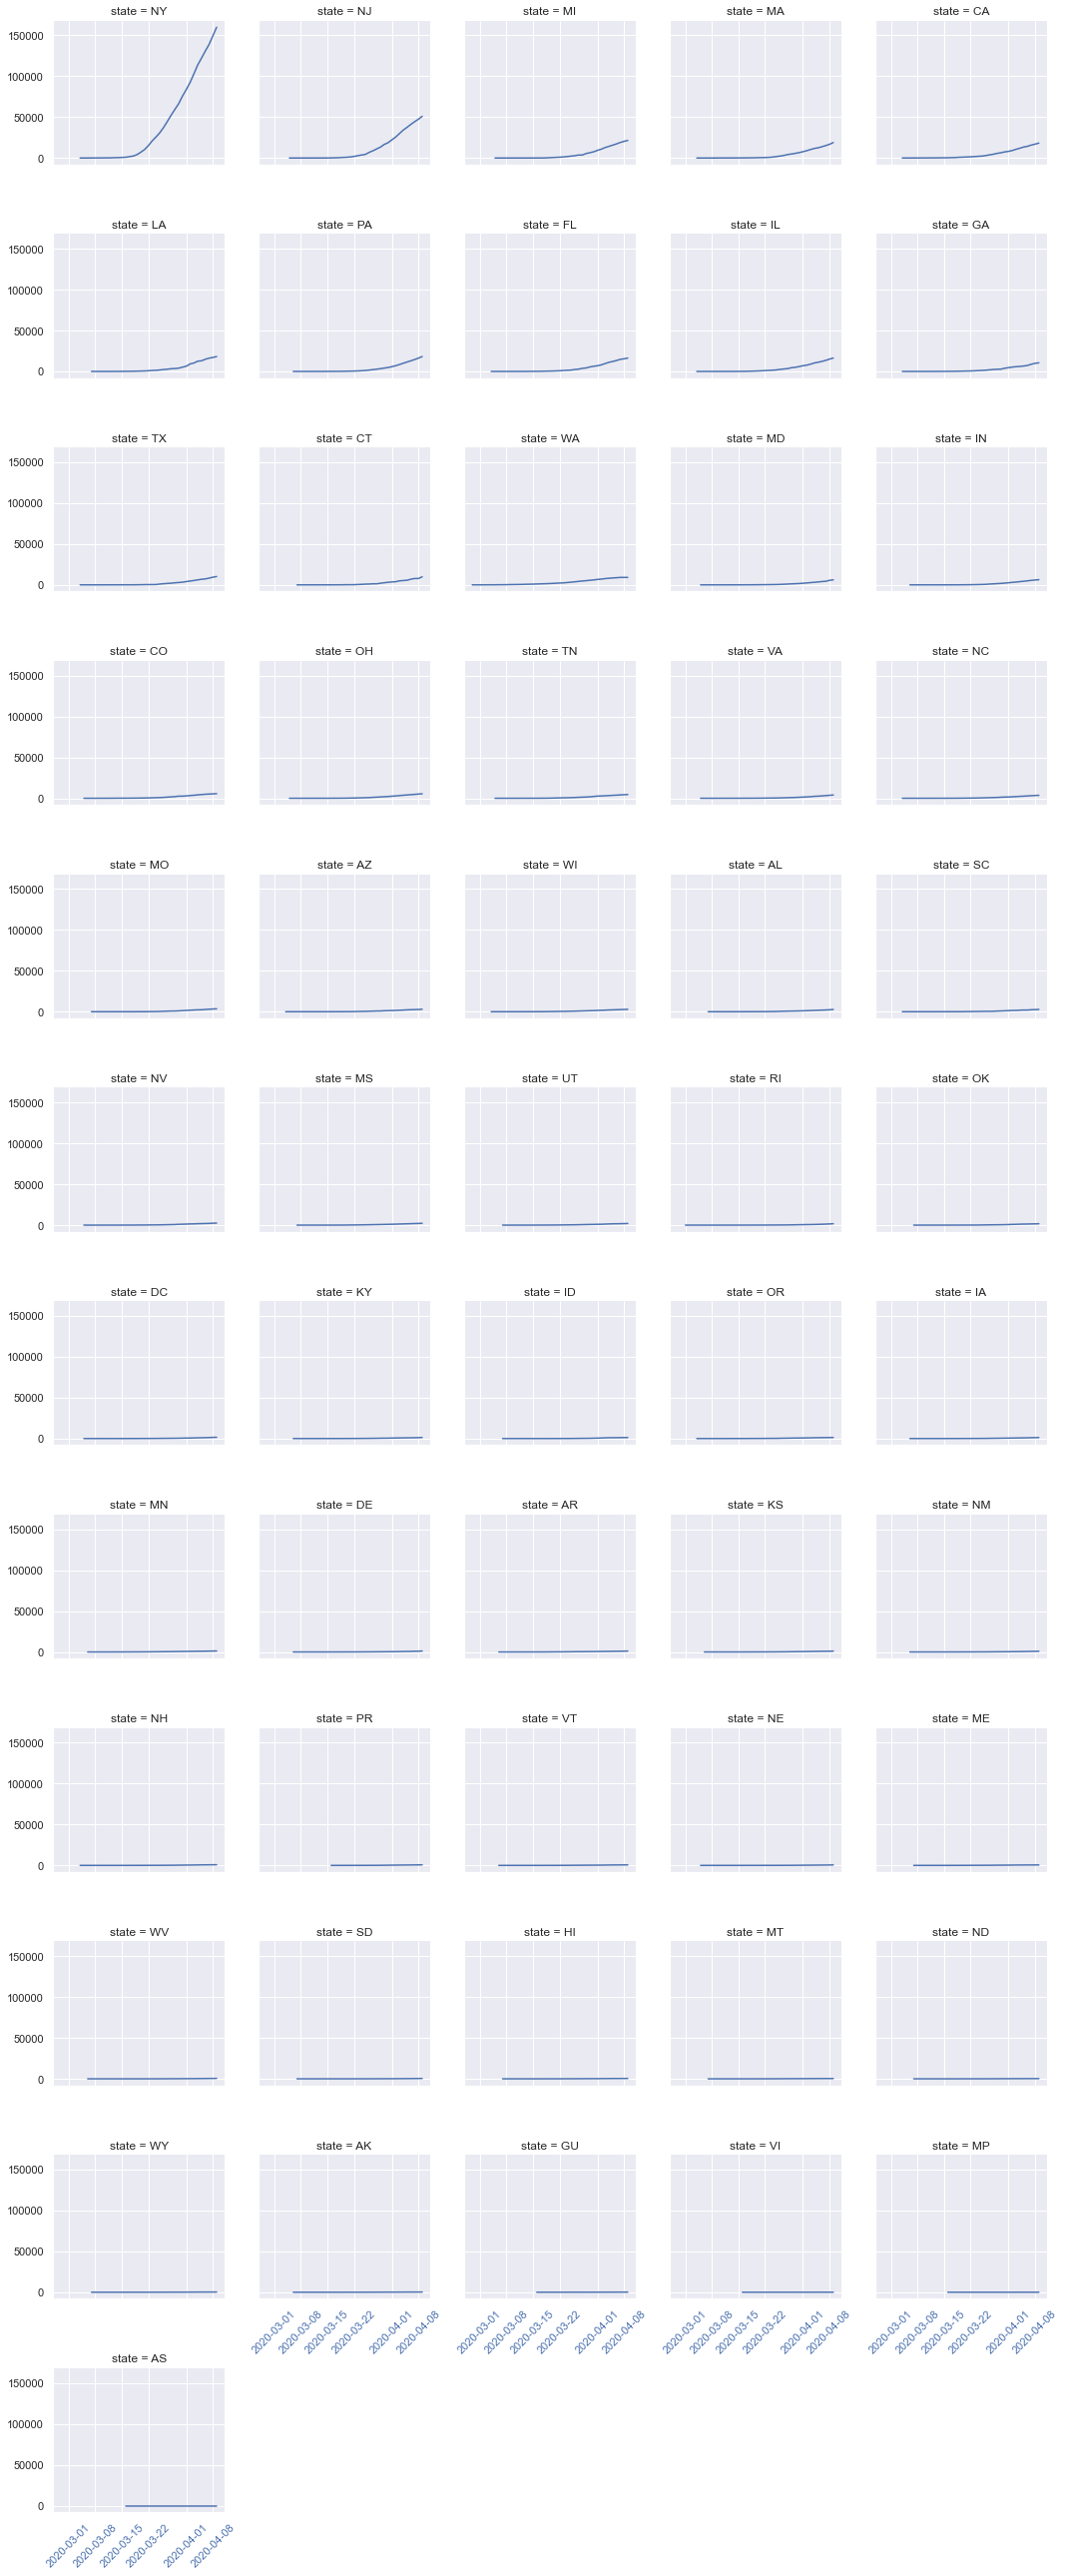

In [18]:
g = sns.FacetGrid(df, col="state", col_wrap=5, height=3, margin_titles=True)
g.map(plt.plot,"date","positive",color="b")
g.map(plt.xticks, rotation=45)